In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [181]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [183]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.IsoPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.106027,0.212053
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.893973,-0.212053


In [184]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    if (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
    stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
    print(f"[Local] Grouping box score rows by GameID...")
    groups = stored_game_boxes.groupby('GameID')
    print(f"[Local] Generated {len(groups)} box score groups by GameID.")
    current = 0
    for (name, group) in groups:
        print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
        group_ratings = group['5FR']
        top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
        bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
        group['5FRDiff'] = [top_diff, bot_diff]
        print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
        current+=1
    print(f"[Local] Finished updating box scores with new 5FR margins.")
print(f"[Local] Writing updated box scores to file...")
stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
print(f"[Local] Wrote updated box scores to file.")

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 32245

[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game_id 322590059.
[96/5670] Updating 5FR Margin for game_id 322590061...
[96/5670] Updated 5FR Margin for game_id 322590061.
[97/5670] Updating 5FR Margin for game_id 322590068...
[97/5670] Updated 5FR Margin for game_id 322590068.
[98/5670] Updating 5FR Margin for game_id 322590077...
[98/5670] Updated 5FR Margin for game_id 322590077.
[99/5670] Updating 5FR Margin for game_id 322590084...
[99/5670] Updated 5FR Margin for game_id 322590084.
[100/5670] Updating 5FR Margin for game_id 322590096...
[100/5670] Updated 5FR Margin for ga

[168/5670] Updated 5FR Margin for game_id 322660356.
[169/5670] Updating 5FR Margin for game_id 322662050...
[169/5670] Updated 5FR Margin for game_id 322662050.
[170/5670] Updating 5FR Margin for game_id 322662229...
[170/5670] Updated 5FR Margin for game_id 322662229.
[171/5670] Updating 5FR Margin for game_id 322662294...
[171/5670] Updated 5FR Margin for game_id 322662294.
[172/5670] Updating 5FR Margin for game_id 322662439...
[172/5670] Updated 5FR Margin for game_id 322662439.
[173/5670] Updating 5FR Margin for game_id 322662459...
[173/5670] Updated 5FR Margin for game_id 322662459.
[174/5670] Updating 5FR Margin for game_id 322662483...
[174/5670] Updated 5FR Margin for game_id 322662483.
[175/5670] Updating 5FR Margin for game_id 322662579...
[175/5670] Updated 5FR Margin for game_id 322662579.
[176/5670] Updating 5FR Margin for game_id 322662628...
[176/5670] Updated 5FR Margin for game_id 322662628.
[177/5670] Updating 5FR Margin for game_id 322662633...
[177/5670] Updated 

[247/5670] Updated 5FR Margin for game_id 322800164.
[248/5670] Updating 5FR Margin for game_id 322800167...
[248/5670] Updated 5FR Margin for game_id 322800167.
[249/5670] Updating 5FR Margin for game_id 322800194...
[249/5670] Updated 5FR Margin for game_id 322800194.
[250/5670] Updating 5FR Margin for game_id 322800195...
[250/5670] Updated 5FR Margin for game_id 322800195.
[251/5670] Updating 5FR Margin for game_id 322800204...
[251/5670] Updated 5FR Margin for game_id 322800204.
[252/5670] Updating 5FR Margin for game_id 322800213...
[252/5670] Updated 5FR Margin for game_id 322800213.
[253/5670] Updating 5FR Margin for game_id 322800218...
[253/5670] Updated 5FR Margin for game_id 322800218.
[254/5670] Updating 5FR Margin for game_id 322800228...
[254/5670] Updated 5FR Margin for game_id 322800228.
[255/5670] Updating 5FR Margin for game_id 322800235...
[255/5670] Updated 5FR Margin for game_id 322800235.
[256/5670] Updating 5FR Margin for game_id 322800248...
[256/5670] Updated 

[325/5670] Updated 5FR Margin for game_id 322872433.
[326/5670] Updating 5FR Margin for game_id 322872439...
[326/5670] Updated 5FR Margin for game_id 322872439.
[327/5670] Updating 5FR Margin for game_id 322872459...
[327/5670] Updated 5FR Margin for game_id 322872459.
[328/5670] Updating 5FR Margin for game_id 322872509...
[328/5670] Updated 5FR Margin for game_id 322872509.
[329/5670] Updating 5FR Margin for game_id 322872641...
[329/5670] Updated 5FR Margin for game_id 322872641.
[330/5670] Updating 5FR Margin for game_id 322872751...
[330/5670] Updated 5FR Margin for game_id 322872751.
[331/5670] Updating 5FR Margin for game_id 322900249...
[331/5670] Updated 5FR Margin for game_id 322900249.
[332/5670] Updating 5FR Margin for game_id 322920009...
[332/5670] Updated 5FR Margin for game_id 322920009.
[333/5670] Updating 5FR Margin for game_id 322922567...
[333/5670] Updated 5FR Margin for game_id 322922567.
[334/5670] Updating 5FR Margin for game_id 322930183...
[334/5670] Updated 

[407/5670] Updated 5FR Margin for game_id 323010151.
[408/5670] Updating 5FR Margin for game_id 323010153...
[408/5670] Updated 5FR Margin for game_id 323010153.
[409/5670] Updating 5FR Margin for game_id 323010158...
[409/5670] Updated 5FR Margin for game_id 323010158.
[410/5670] Updating 5FR Margin for game_id 323010164...
[410/5670] Updated 5FR Margin for game_id 323010164.
[411/5670] Updating 5FR Margin for game_id 323010166...
[411/5670] Updated 5FR Margin for game_id 323010166.
[412/5670] Updating 5FR Margin for game_id 323010167...
[412/5670] Updated 5FR Margin for game_id 323010167.
[413/5670] Updating 5FR Margin for game_id 323010189...
[413/5670] Updated 5FR Margin for game_id 323010189.
[414/5670] Updating 5FR Margin for game_id 323010193...
[414/5670] Updated 5FR Margin for game_id 323010193.
[415/5670] Updating 5FR Margin for game_id 323010197...
[415/5670] Updated 5FR Margin for game_id 323010197.
[416/5670] Updating 5FR Margin for game_id 323010201...
[416/5670] Updated 

[494/5670] Updated 5FR Margin for game_id 323082572.
[495/5670] Updating 5FR Margin for game_id 323082633...
[495/5670] Updated 5FR Margin for game_id 323082633.
[496/5670] Updating 5FR Margin for game_id 323082641...
[496/5670] Updated 5FR Margin for game_id 323082641.
[497/5670] Updating 5FR Margin for game_id 323082655...
[497/5670] Updated 5FR Margin for game_id 323082655.
[498/5670] Updating 5FR Margin for game_id 323082751...
[498/5670] Updated 5FR Margin for game_id 323082751.
[499/5670] Updating 5FR Margin for game_id 323112649...
[499/5670] Updated 5FR Margin for game_id 323112649.
[500/5670] Updating 5FR Margin for game_id 323120195...
[500/5670] Updated 5FR Margin for game_id 323120195.
[501/5670] Updating 5FR Margin for game_id 323130259...
[501/5670] Updated 5FR Margin for game_id 323130259.
[502/5670] Updating 5FR Margin for game_id 323132032...
[502/5670] Updated 5FR Margin for game_id 323132032.
[503/5670] Updating 5FR Margin for game_id 323140041...
[503/5670] Updated 

[575/5670] Updated 5FR Margin for game_id 323220167.
[576/5670] Updating 5FR Margin for game_id 323220189...
[576/5670] Updated 5FR Margin for game_id 323220189.
[577/5670] Updating 5FR Margin for game_id 323220197...
[577/5670] Updated 5FR Margin for game_id 323220197.
[578/5670] Updating 5FR Margin for game_id 323220202...
[578/5670] Updated 5FR Margin for game_id 323220202.
[579/5670] Updating 5FR Margin for game_id 323220204...
[579/5670] Updated 5FR Margin for game_id 323220204.
[580/5670] Updating 5FR Margin for game_id 323220213...
[580/5670] Updated 5FR Margin for game_id 323220213.
[581/5670] Updating 5FR Margin for game_id 323220228...
[581/5670] Updated 5FR Margin for game_id 323220228.
[582/5670] Updating 5FR Margin for game_id 323220238...
[582/5670] Updated 5FR Margin for game_id 323220238.
[583/5670] Updating 5FR Margin for game_id 323220239...
[583/5670] Updated 5FR Margin for game_id 323220239.
[584/5670] Updating 5FR Margin for game_id 323220242...
[584/5670] Updated 

[653/5670] Updated 5FR Margin for game_id 323292229.
[654/5670] Updating 5FR Margin for game_id 323292393...
[654/5670] Updated 5FR Margin for game_id 323292393.
[655/5670] Updating 5FR Margin for game_id 323292509...
[655/5670] Updated 5FR Margin for game_id 323292509.
[656/5670] Updating 5FR Margin for game_id 323292567...
[656/5670] Updated 5FR Margin for game_id 323292567.
[657/5670] Updating 5FR Margin for game_id 323292633...
[657/5670] Updated 5FR Margin for game_id 323292633.
[658/5670] Updating 5FR Margin for game_id 323292636...
[658/5670] Updated 5FR Margin for game_id 323292636.
[659/5670] Updating 5FR Margin for game_id 323292638...
[659/5670] Updated 5FR Margin for game_id 323292638.
[660/5670] Updating 5FR Margin for game_id 323292641...
[660/5670] Updated 5FR Margin for game_id 323292641.
[661/5670] Updating 5FR Margin for game_id 323292751...
[661/5670] Updated 5FR Margin for game_id 323292751.
[662/5670] Updating 5FR Margin for game_id 323340164...
[662/5670] Updated 

[735/5670] Updated 5FR Margin for game_id 332500096.
[736/5670] Updating 5FR Margin for game_id 332500099...
[736/5670] Updated 5FR Margin for game_id 332500099.
[737/5670] Updating 5FR Margin for game_id 332500120...
[737/5670] Updated 5FR Margin for game_id 332500120.
[738/5670] Updating 5FR Margin for game_id 332500127...
[738/5670] Updated 5FR Margin for game_id 332500127.
[739/5670] Updating 5FR Margin for game_id 332500130...
[739/5670] Updated 5FR Margin for game_id 332500130.
[740/5670] Updating 5FR Margin for game_id 332500142...
[740/5670] Updated 5FR Margin for game_id 332500142.
[741/5670] Updating 5FR Margin for game_id 332500153...
[741/5670] Updated 5FR Margin for game_id 332500153.
[742/5670] Updating 5FR Margin for game_id 332500158...
[742/5670] Updated 5FR Margin for game_id 332500158.
[743/5670] Updating 5FR Margin for game_id 332500166...
[743/5670] Updated 5FR Margin for game_id 332500166.
[744/5670] Updating 5FR Margin for game_id 332500194...
[744/5670] Updated 

[813/5670] Updated 5FR Margin for game_id 332640024.
[814/5670] Updating 5FR Margin for game_id 332640026...
[814/5670] Updated 5FR Margin for game_id 332640026.
[815/5670] Updating 5FR Margin for game_id 332640030...
[815/5670] Updated 5FR Margin for game_id 332640030.
[816/5670] Updating 5FR Margin for game_id 332640041...
[816/5670] Updated 5FR Margin for game_id 332640041.
[817/5670] Updating 5FR Margin for game_id 332640057...
[817/5670] Updated 5FR Margin for game_id 332640057.
[818/5670] Updating 5FR Margin for game_id 332640059...
[818/5670] Updated 5FR Margin for game_id 332640059.
[819/5670] Updating 5FR Margin for game_id 332640061...
[819/5670] Updated 5FR Margin for game_id 332640061.
[820/5670] Updating 5FR Margin for game_id 332640084...
[820/5670] Updated 5FR Margin for game_id 332640084.
[821/5670] Updating 5FR Margin for game_id 332640087...
[821/5670] Updated 5FR Margin for game_id 332640087.
[822/5670] Updating 5FR Margin for game_id 332640097...
[822/5670] Updated 

[891/5670] Updated 5FR Margin for game_id 332712348.
[892/5670] Updating 5FR Margin for game_id 332712433...
[892/5670] Updated 5FR Margin for game_id 332712433.
[893/5670] Updating 5FR Margin for game_id 332712440...
[893/5670] Updated 5FR Margin for game_id 332712440.
[894/5670] Updating 5FR Margin for game_id 332712483...
[894/5670] Updated 5FR Margin for game_id 332712483.
[895/5670] Updating 5FR Margin for game_id 332712509...
[895/5670] Updated 5FR Margin for game_id 332712509.
[896/5670] Updating 5FR Margin for game_id 332712628...
[896/5670] Updated 5FR Margin for game_id 332712628.
[897/5670] Updating 5FR Margin for game_id 332712633...
[897/5670] Updated 5FR Margin for game_id 332712633.
[898/5670] Updating 5FR Margin for game_id 332712636...
[898/5670] Updated 5FR Margin for game_id 332712636.
[899/5670] Updating 5FR Margin for game_id 332712711...
[899/5670] Updated 5FR Margin for game_id 332712711.
[900/5670] Updating 5FR Margin for game_id 332760066...
[900/5670] Updated 

[979/5670] Updated 5FR Margin for game_id 332850252.
[980/5670] Updating 5FR Margin for game_id 332850254...
[980/5670] Updated 5FR Margin for game_id 332850254.
[981/5670] Updating 5FR Margin for game_id 332850259...
[981/5670] Updated 5FR Margin for game_id 332850259.
[982/5670] Updating 5FR Margin for game_id 332850264...
[982/5670] Updated 5FR Margin for game_id 332850264.
[983/5670] Updating 5FR Margin for game_id 332850265...
[983/5670] Updated 5FR Margin for game_id 332850265.
[984/5670] Updating 5FR Margin for game_id 332850275...
[984/5670] Updated 5FR Margin for game_id 332850275.
[985/5670] Updating 5FR Margin for game_id 332850326...
[985/5670] Updated 5FR Margin for game_id 332850326.
[986/5670] Updating 5FR Margin for game_id 332850328...
[986/5670] Updated 5FR Margin for game_id 332850328.
[987/5670] Updating 5FR Margin for game_id 332850344...
[987/5670] Updated 5FR Margin for game_id 332850344.
[988/5670] Updating 5FR Margin for game_id 332850349...
[988/5670] Updated 

[1062/5670] Updated 5FR Margin for game_id 332990058.
[1063/5670] Updating 5FR Margin for game_id 332990062...
[1063/5670] Updated 5FR Margin for game_id 332990062.
[1064/5670] Updating 5FR Margin for game_id 332990066...
[1064/5670] Updated 5FR Margin for game_id 332990066.
[1065/5670] Updating 5FR Margin for game_id 332990098...
[1065/5670] Updated 5FR Margin for game_id 332990098.
[1066/5670] Updating 5FR Margin for game_id 332990113...
[1066/5670] Updated 5FR Margin for game_id 332990113.
[1067/5670] Updating 5FR Margin for game_id 332990120...
[1067/5670] Updated 5FR Margin for game_id 332990120.
[1068/5670] Updating 5FR Margin for game_id 332990135...
[1068/5670] Updated 5FR Margin for game_id 332990135.
[1069/5670] Updating 5FR Margin for game_id 332990142...
[1069/5670] Updated 5FR Margin for game_id 332990142.
[1070/5670] Updating 5FR Margin for game_id 332990153...
[1070/5670] Updated 5FR Margin for game_id 332990153.
[1071/5670] Updating 5FR Margin for game_id 332990164...
[

[1140/5670] Updated 5FR Margin for game_id 333062006.
[1141/5670] Updating 5FR Margin for game_id 333062226...
[1141/5670] Updated 5FR Margin for game_id 333062226.
[1142/5670] Updating 5FR Margin for game_id 333062229...
[1142/5670] Updated 5FR Margin for game_id 333062229.
[1143/5670] Updating 5FR Margin for game_id 333062247...
[1143/5670] Updated 5FR Margin for game_id 333062247.
[1144/5670] Updating 5FR Margin for game_id 333062294...
[1144/5670] Updated 5FR Margin for game_id 333062294.
[1145/5670] Updating 5FR Margin for game_id 333062306...
[1145/5670] Updated 5FR Margin for game_id 333062306.
[1146/5670] Updating 5FR Margin for game_id 333062439...
[1146/5670] Updated 5FR Margin for game_id 333062439.
[1147/5670] Updating 5FR Margin for game_id 333062509...
[1147/5670] Updated 5FR Margin for game_id 333062509.
[1148/5670] Updating 5FR Margin for game_id 333062579...
[1148/5670] Updated 5FR Margin for game_id 333062579.
[1149/5670] Updating 5FR Margin for game_id 333062628...
[

[1215/5670] Updated 5FR Margin for game_id 333200052.
[1216/5670] Updating 5FR Margin for game_id 333200058...
[1216/5670] Updated 5FR Margin for game_id 333200058.
[1217/5670] Updating 5FR Margin for game_id 333200062...
[1217/5670] Updated 5FR Margin for game_id 333200062.
[1218/5670] Updating 5FR Margin for game_id 333200068...
[1218/5670] Updated 5FR Margin for game_id 333200068.
[1219/5670] Updating 5FR Margin for game_id 333200077...
[1219/5670] Updated 5FR Margin for game_id 333200077.
[1220/5670] Updating 5FR Margin for game_id 333200097...
[1220/5670] Updated 5FR Margin for game_id 333200097.
[1221/5670] Updating 5FR Margin for game_id 333200103...
[1221/5670] Updated 5FR Margin for game_id 333200103.
[1222/5670] Updating 5FR Margin for game_id 333200113...
[1222/5670] Updated 5FR Margin for game_id 333200113.
[1223/5670] Updating 5FR Margin for game_id 333200145...
[1223/5670] Updated 5FR Margin for game_id 333200145.
[1224/5670] Updating 5FR Margin for game_id 333200150...
[

[1292/5670] Updated 5FR Margin for game_id 333270328.
[1293/5670] Updating 5FR Margin for game_id 333272032...
[1293/5670] Updated 5FR Margin for game_id 333272032.
[1294/5670] Updating 5FR Margin for game_id 333272117...
[1294/5670] Updated 5FR Margin for game_id 333272117.
[1295/5670] Updating 5FR Margin for game_id 333272199...
[1295/5670] Updated 5FR Margin for game_id 333272199.
[1296/5670] Updating 5FR Margin for game_id 333272226...
[1296/5670] Updated 5FR Margin for game_id 333272226.
[1297/5670] Updating 5FR Margin for game_id 333272229...
[1297/5670] Updated 5FR Margin for game_id 333272229.
[1298/5670] Updating 5FR Margin for game_id 333272294...
[1298/5670] Updated 5FR Margin for game_id 333272294.
[1299/5670] Updating 5FR Margin for game_id 333272306...
[1299/5670] Updated 5FR Margin for game_id 333272306.
[1300/5670] Updating 5FR Margin for game_id 333272348...
[1300/5670] Updated 5FR Margin for game_id 333272348.
[1301/5670] Updating 5FR Margin for game_id 333272390...
[

[1370/5670] Updated 5FR Margin for game_id 333410009.
[1371/5670] Updating 5FR Margin for game_id 333410041...
[1371/5670] Updated 5FR Margin for game_id 333410041.
[1372/5670] Updating 5FR Margin for game_id 333410052...
[1372/5670] Updated 5FR Margin for game_id 333410052.
[1373/5670] Updating 5FR Margin for game_id 333410127...
[1373/5670] Updated 5FR Margin for game_id 333410127.
[1374/5670] Updating 5FR Margin for game_id 333410164...
[1374/5670] Updated 5FR Margin for game_id 333410164.
[1375/5670] Updating 5FR Margin for game_id 333410197...
[1375/5670] Updated 5FR Margin for game_id 333410197.
[1376/5670] Updating 5FR Margin for game_id 333410239...
[1376/5670] Updated 5FR Margin for game_id 333410239.
[1377/5670] Updating 5FR Margin for game_id 333410242...
[1377/5670] Updated 5FR Margin for game_id 333410242.
[1378/5670] Updating 5FR Margin for game_id 333410278...
[1378/5670] Updated 5FR Margin for game_id 333410278.
[1379/5670] Updating 5FR Margin for game_id 333412567...
[

[1449/5670] Updated 5FR Margin for game_id 400547719.
[1450/5670] Updating 5FR Margin for game_id 400547720...
[1450/5670] Updated 5FR Margin for game_id 400547720.
[1451/5670] Updating 5FR Margin for game_id 400547721...
[1451/5670] Updated 5FR Margin for game_id 400547721.
[1452/5670] Updating 5FR Margin for game_id 400547722...
[1452/5670] Updated 5FR Margin for game_id 400547722.
[1453/5670] Updating 5FR Margin for game_id 400547723...
[1453/5670] Updated 5FR Margin for game_id 400547723.
[1454/5670] Updating 5FR Margin for game_id 400547724...
[1454/5670] Updated 5FR Margin for game_id 400547724.
[1455/5670] Updating 5FR Margin for game_id 400547725...
[1455/5670] Updated 5FR Margin for game_id 400547725.
[1456/5670] Updating 5FR Margin for game_id 400547726...
[1456/5670] Updated 5FR Margin for game_id 400547726.
[1457/5670] Updating 5FR Margin for game_id 400547727...
[1457/5670] Updated 5FR Margin for game_id 400547727.
[1458/5670] Updating 5FR Margin for game_id 400547728...
[

[1528/5670] Updated 5FR Margin for game_id 400547806.
[1529/5670] Updating 5FR Margin for game_id 400547807...
[1529/5670] Updated 5FR Margin for game_id 400547807.
[1530/5670] Updating 5FR Margin for game_id 400547810...
[1530/5670] Updated 5FR Margin for game_id 400547810.
[1531/5670] Updating 5FR Margin for game_id 400547811...
[1531/5670] Updated 5FR Margin for game_id 400547811.
[1532/5670] Updating 5FR Margin for game_id 400547812...
[1532/5670] Updated 5FR Margin for game_id 400547812.
[1533/5670] Updating 5FR Margin for game_id 400547813...
[1533/5670] Updated 5FR Margin for game_id 400547813.
[1534/5670] Updating 5FR Margin for game_id 400547814...
[1534/5670] Updated 5FR Margin for game_id 400547814.
[1535/5670] Updating 5FR Margin for game_id 400547816...
[1535/5670] Updated 5FR Margin for game_id 400547816.
[1536/5670] Updating 5FR Margin for game_id 400547817...
[1536/5670] Updated 5FR Margin for game_id 400547817.
[1537/5670] Updating 5FR Margin for game_id 400547818...
[

[1605/5670] Updated 5FR Margin for game_id 400547898.
[1606/5670] Updating 5FR Margin for game_id 400547899...
[1606/5670] Updated 5FR Margin for game_id 400547899.
[1607/5670] Updating 5FR Margin for game_id 400547900...
[1607/5670] Updated 5FR Margin for game_id 400547900.
[1608/5670] Updating 5FR Margin for game_id 400547901...
[1608/5670] Updated 5FR Margin for game_id 400547901.
[1609/5670] Updating 5FR Margin for game_id 400547902...
[1609/5670] Updated 5FR Margin for game_id 400547902.
[1610/5670] Updating 5FR Margin for game_id 400547903...
[1610/5670] Updated 5FR Margin for game_id 400547903.
[1611/5670] Updating 5FR Margin for game_id 400547905...
[1611/5670] Updated 5FR Margin for game_id 400547905.
[1612/5670] Updating 5FR Margin for game_id 400547906...
[1612/5670] Updated 5FR Margin for game_id 400547906.
[1613/5670] Updating 5FR Margin for game_id 400547907...
[1613/5670] Updated 5FR Margin for game_id 400547907.
[1614/5670] Updating 5FR Margin for game_id 400547908...
[

[1684/5670] Updated 5FR Margin for game_id 400547986.
[1685/5670] Updating 5FR Margin for game_id 400547987...
[1685/5670] Updated 5FR Margin for game_id 400547987.
[1686/5670] Updating 5FR Margin for game_id 400547988...
[1686/5670] Updated 5FR Margin for game_id 400547988.
[1687/5670] Updating 5FR Margin for game_id 400547989...
[1687/5670] Updated 5FR Margin for game_id 400547989.
[1688/5670] Updating 5FR Margin for game_id 400547990...
[1688/5670] Updated 5FR Margin for game_id 400547990.
[1689/5670] Updating 5FR Margin for game_id 400547992...
[1689/5670] Updated 5FR Margin for game_id 400547992.
[1690/5670] Updating 5FR Margin for game_id 400547993...
[1690/5670] Updated 5FR Margin for game_id 400547993.
[1691/5670] Updating 5FR Margin for game_id 400547995...
[1691/5670] Updated 5FR Margin for game_id 400547995.
[1692/5670] Updating 5FR Margin for game_id 400547996...
[1692/5670] Updated 5FR Margin for game_id 400547996.
[1693/5670] Updating 5FR Margin for game_id 400547997...
[

[1763/5670] Updated 5FR Margin for game_id 400548082.
[1764/5670] Updating 5FR Margin for game_id 400548083...
[1764/5670] Updated 5FR Margin for game_id 400548083.
[1765/5670] Updating 5FR Margin for game_id 400548084...
[1765/5670] Updated 5FR Margin for game_id 400548084.
[1766/5670] Updating 5FR Margin for game_id 400548085...
[1766/5670] Updated 5FR Margin for game_id 400548085.
[1767/5670] Updating 5FR Margin for game_id 400548086...
[1767/5670] Updated 5FR Margin for game_id 400548086.
[1768/5670] Updating 5FR Margin for game_id 400548087...
[1768/5670] Updated 5FR Margin for game_id 400548087.
[1769/5670] Updating 5FR Margin for game_id 400548088...
[1769/5670] Updated 5FR Margin for game_id 400548088.
[1770/5670] Updating 5FR Margin for game_id 400548089...
[1770/5670] Updated 5FR Margin for game_id 400548089.
[1771/5670] Updating 5FR Margin for game_id 400548097...
[1771/5670] Updated 5FR Margin for game_id 400548097.
[1772/5670] Updating 5FR Margin for game_id 400548098...
[

[1847/5670] Updated 5FR Margin for game_id 400548194.
[1848/5670] Updating 5FR Margin for game_id 400548196...
[1848/5670] Updated 5FR Margin for game_id 400548196.
[1849/5670] Updating 5FR Margin for game_id 400548197...
[1849/5670] Updated 5FR Margin for game_id 400548197.
[1850/5670] Updating 5FR Margin for game_id 400548198...
[1850/5670] Updated 5FR Margin for game_id 400548198.
[1851/5670] Updating 5FR Margin for game_id 400548199...
[1851/5670] Updated 5FR Margin for game_id 400548199.
[1852/5670] Updating 5FR Margin for game_id 400548200...
[1852/5670] Updated 5FR Margin for game_id 400548200.
[1853/5670] Updating 5FR Margin for game_id 400548201...
[1853/5670] Updated 5FR Margin for game_id 400548201.
[1854/5670] Updating 5FR Margin for game_id 400548202...
[1854/5670] Updated 5FR Margin for game_id 400548202.
[1855/5670] Updating 5FR Margin for game_id 400548203...
[1855/5670] Updated 5FR Margin for game_id 400548203.
[1856/5670] Updating 5FR Margin for game_id 400548204...
[

[1921/5670] Updated 5FR Margin for game_id 400548281.
[1922/5670] Updating 5FR Margin for game_id 400548282...
[1922/5670] Updated 5FR Margin for game_id 400548282.
[1923/5670] Updating 5FR Margin for game_id 400548283...
[1923/5670] Updated 5FR Margin for game_id 400548283.
[1924/5670] Updating 5FR Margin for game_id 400548284...
[1924/5670] Updated 5FR Margin for game_id 400548284.
[1925/5670] Updating 5FR Margin for game_id 400548285...
[1925/5670] Updated 5FR Margin for game_id 400548285.
[1926/5670] Updating 5FR Margin for game_id 400548286...
[1926/5670] Updated 5FR Margin for game_id 400548286.
[1927/5670] Updating 5FR Margin for game_id 400548287...
[1927/5670] Updated 5FR Margin for game_id 400548287.
[1928/5670] Updating 5FR Margin for game_id 400548288...
[1928/5670] Updated 5FR Margin for game_id 400548288.
[1929/5670] Updating 5FR Margin for game_id 400548289...
[1929/5670] Updated 5FR Margin for game_id 400548289.
[1930/5670] Updating 5FR Margin for game_id 400548290...
[

[1999/5670] Updated 5FR Margin for game_id 400548366.
[2000/5670] Updating 5FR Margin for game_id 400548367...
[2000/5670] Updated 5FR Margin for game_id 400548367.
[2001/5670] Updating 5FR Margin for game_id 400548368...
[2001/5670] Updated 5FR Margin for game_id 400548368.
[2002/5670] Updating 5FR Margin for game_id 400548369...
[2002/5670] Updated 5FR Margin for game_id 400548369.
[2003/5670] Updating 5FR Margin for game_id 400548370...
[2003/5670] Updated 5FR Margin for game_id 400548370.
[2004/5670] Updating 5FR Margin for game_id 400548373...
[2004/5670] Updated 5FR Margin for game_id 400548373.
[2005/5670] Updating 5FR Margin for game_id 400548374...
[2005/5670] Updated 5FR Margin for game_id 400548374.
[2006/5670] Updating 5FR Margin for game_id 400548375...
[2006/5670] Updated 5FR Margin for game_id 400548375.
[2007/5670] Updating 5FR Margin for game_id 400548376...
[2007/5670] Updated 5FR Margin for game_id 400548376.
[2008/5670] Updating 5FR Margin for game_id 400548377...
[

[2074/5670] Updated 5FR Margin for game_id 400603830.
[2075/5670] Updating 5FR Margin for game_id 400603831...
[2075/5670] Updated 5FR Margin for game_id 400603831.
[2076/5670] Updating 5FR Margin for game_id 400603832...
[2076/5670] Updated 5FR Margin for game_id 400603832.
[2077/5670] Updating 5FR Margin for game_id 400603836...
[2077/5670] Updated 5FR Margin for game_id 400603836.
[2078/5670] Updating 5FR Margin for game_id 400603838...
[2078/5670] Updated 5FR Margin for game_id 400603838.
[2079/5670] Updating 5FR Margin for game_id 400603839...
[2079/5670] Updated 5FR Margin for game_id 400603839.
[2080/5670] Updating 5FR Margin for game_id 400603840...
[2080/5670] Updated 5FR Margin for game_id 400603840.
[2081/5670] Updating 5FR Margin for game_id 400603841...
[2081/5670] Updated 5FR Margin for game_id 400603841.
[2082/5670] Updating 5FR Margin for game_id 400603842...
[2082/5670] Updated 5FR Margin for game_id 400603842.
[2083/5670] Updating 5FR Margin for game_id 400603843...
[

[2148/5670] Updated 5FR Margin for game_id 400603915.
[2149/5670] Updating 5FR Margin for game_id 400603916...
[2149/5670] Updated 5FR Margin for game_id 400603916.
[2150/5670] Updating 5FR Margin for game_id 400603917...
[2150/5670] Updated 5FR Margin for game_id 400603917.
[2151/5670] Updating 5FR Margin for game_id 400603918...
[2151/5670] Updated 5FR Margin for game_id 400603918.
[2152/5670] Updating 5FR Margin for game_id 400603919...
[2152/5670] Updated 5FR Margin for game_id 400603919.
[2153/5670] Updating 5FR Margin for game_id 400603920...
[2153/5670] Updated 5FR Margin for game_id 400603920.
[2154/5670] Updating 5FR Margin for game_id 400603922...
[2154/5670] Updated 5FR Margin for game_id 400603922.
[2155/5670] Updating 5FR Margin for game_id 400603924...
[2155/5670] Updated 5FR Margin for game_id 400603924.
[2156/5670] Updating 5FR Margin for game_id 400603925...
[2156/5670] Updated 5FR Margin for game_id 400603925.
[2157/5670] Updating 5FR Margin for game_id 400603926...
[

[2226/5670] Updated 5FR Margin for game_id 400756957.
[2227/5670] Updating 5FR Margin for game_id 400756958...
[2227/5670] Updated 5FR Margin for game_id 400756958.
[2228/5670] Updating 5FR Margin for game_id 400756959...
[2228/5670] Updated 5FR Margin for game_id 400756959.
[2229/5670] Updating 5FR Margin for game_id 400756960...
[2229/5670] Updated 5FR Margin for game_id 400756960.
[2230/5670] Updating 5FR Margin for game_id 400756961...
[2230/5670] Updated 5FR Margin for game_id 400756961.
[2231/5670] Updating 5FR Margin for game_id 400756962...
[2231/5670] Updated 5FR Margin for game_id 400756962.
[2232/5670] Updating 5FR Margin for game_id 400756963...
[2232/5670] Updated 5FR Margin for game_id 400756963.
[2233/5670] Updating 5FR Margin for game_id 400756964...
[2233/5670] Updated 5FR Margin for game_id 400756964.
[2234/5670] Updating 5FR Margin for game_id 400756965...
[2234/5670] Updated 5FR Margin for game_id 400756965.
[2235/5670] Updating 5FR Margin for game_id 400756966...
[

[2301/5670] Updated 5FR Margin for game_id 400757054.
[2302/5670] Updating 5FR Margin for game_id 400757055...
[2302/5670] Updated 5FR Margin for game_id 400757055.
[2303/5670] Updating 5FR Margin for game_id 400757056...
[2303/5670] Updated 5FR Margin for game_id 400757056.
[2304/5670] Updating 5FR Margin for game_id 400757057...
[2304/5670] Updated 5FR Margin for game_id 400757057.
[2305/5670] Updating 5FR Margin for game_id 400757058...
[2305/5670] Updated 5FR Margin for game_id 400757058.
[2306/5670] Updating 5FR Margin for game_id 400757059...
[2306/5670] Updated 5FR Margin for game_id 400757059.
[2307/5670] Updating 5FR Margin for game_id 400757060...
[2307/5670] Updated 5FR Margin for game_id 400757060.
[2308/5670] Updating 5FR Margin for game_id 400757061...
[2308/5670] Updated 5FR Margin for game_id 400757061.
[2309/5670] Updating 5FR Margin for game_id 400757062...
[2309/5670] Updated 5FR Margin for game_id 400757062.
[2310/5670] Updating 5FR Margin for game_id 400757063...
[

[2375/5670] Updated 5FR Margin for game_id 400763435.
[2376/5670] Updating 5FR Margin for game_id 400763436...
[2376/5670] Updated 5FR Margin for game_id 400763436.
[2377/5670] Updating 5FR Margin for game_id 400763437...
[2377/5670] Updated 5FR Margin for game_id 400763437.
[2378/5670] Updating 5FR Margin for game_id 400763438...
[2378/5670] Updated 5FR Margin for game_id 400763438.
[2379/5670] Updating 5FR Margin for game_id 400763439...
[2379/5670] Updated 5FR Margin for game_id 400763439.
[2380/5670] Updating 5FR Margin for game_id 400763440...
[2380/5670] Updated 5FR Margin for game_id 400763440.
[2381/5670] Updating 5FR Margin for game_id 400763441...
[2381/5670] Updated 5FR Margin for game_id 400763441.
[2382/5670] Updating 5FR Margin for game_id 400763442...
[2382/5670] Updated 5FR Margin for game_id 400763442.
[2383/5670] Updating 5FR Margin for game_id 400763443...
[2383/5670] Updated 5FR Margin for game_id 400763443.
[2384/5670] Updating 5FR Margin for game_id 400763444...
[

[2452/5670] Updated 5FR Margin for game_id 400763540.
[2453/5670] Updating 5FR Margin for game_id 400763541...
[2453/5670] Updated 5FR Margin for game_id 400763541.
[2454/5670] Updating 5FR Margin for game_id 400763542...
[2454/5670] Updated 5FR Margin for game_id 400763542.
[2455/5670] Updating 5FR Margin for game_id 400763543...
[2455/5670] Updated 5FR Margin for game_id 400763543.
[2456/5670] Updating 5FR Margin for game_id 400763544...
[2456/5670] Updated 5FR Margin for game_id 400763544.
[2457/5670] Updating 5FR Margin for game_id 400763545...
[2457/5670] Updated 5FR Margin for game_id 400763545.
[2458/5670] Updating 5FR Margin for game_id 400763546...
[2458/5670] Updated 5FR Margin for game_id 400763546.
[2459/5670] Updating 5FR Margin for game_id 400763547...
[2459/5670] Updated 5FR Margin for game_id 400763547.
[2460/5670] Updating 5FR Margin for game_id 400763548...
[2460/5670] Updated 5FR Margin for game_id 400763548.
[2461/5670] Updating 5FR Margin for game_id 400763549...
[

[2526/5670] Updated 5FR Margin for game_id 400763625.
[2527/5670] Updating 5FR Margin for game_id 400763626...
[2527/5670] Updated 5FR Margin for game_id 400763626.
[2528/5670] Updating 5FR Margin for game_id 400763627...
[2528/5670] Updated 5FR Margin for game_id 400763627.
[2529/5670] Updating 5FR Margin for game_id 400763628...
[2529/5670] Updated 5FR Margin for game_id 400763628.
[2530/5670] Updating 5FR Margin for game_id 400763629...
[2530/5670] Updated 5FR Margin for game_id 400763629.
[2531/5670] Updating 5FR Margin for game_id 400763630...
[2531/5670] Updated 5FR Margin for game_id 400763630.
[2532/5670] Updating 5FR Margin for game_id 400763631...
[2532/5670] Updated 5FR Margin for game_id 400763631.
[2533/5670] Updating 5FR Margin for game_id 400763632...
[2533/5670] Updated 5FR Margin for game_id 400763632.
[2534/5670] Updating 5FR Margin for game_id 400763633...
[2534/5670] Updated 5FR Margin for game_id 400763633.
[2535/5670] Updating 5FR Margin for game_id 400763634...
[

[2607/5670] Updated 5FR Margin for game_id 400764906.
[2608/5670] Updating 5FR Margin for game_id 400764907...
[2608/5670] Updated 5FR Margin for game_id 400764907.
[2609/5670] Updating 5FR Margin for game_id 400764908...
[2609/5670] Updated 5FR Margin for game_id 400764908.
[2610/5670] Updating 5FR Margin for game_id 400764909...
[2610/5670] Updated 5FR Margin for game_id 400764909.
[2611/5670] Updating 5FR Margin for game_id 400764910...
[2611/5670] Updated 5FR Margin for game_id 400764910.
[2612/5670] Updating 5FR Margin for game_id 400764911...
[2612/5670] Updated 5FR Margin for game_id 400764911.
[2613/5670] Updating 5FR Margin for game_id 400764912...
[2613/5670] Updated 5FR Margin for game_id 400764912.
[2614/5670] Updating 5FR Margin for game_id 400764913...
[2614/5670] Updated 5FR Margin for game_id 400764913.
[2615/5670] Updating 5FR Margin for game_id 400764914...
[2615/5670] Updated 5FR Margin for game_id 400764914.
[2616/5670] Updating 5FR Margin for game_id 400764915...
[

[2681/5670] Updated 5FR Margin for game_id 400787315.
[2682/5670] Updating 5FR Margin for game_id 400787316...
[2682/5670] Updated 5FR Margin for game_id 400787316.
[2683/5670] Updating 5FR Margin for game_id 400787317...
[2683/5670] Updated 5FR Margin for game_id 400787317.
[2684/5670] Updating 5FR Margin for game_id 400787318...
[2684/5670] Updated 5FR Margin for game_id 400787318.
[2685/5670] Updating 5FR Margin for game_id 400787319...
[2685/5670] Updated 5FR Margin for game_id 400787319.
[2686/5670] Updating 5FR Margin for game_id 400787320...
[2686/5670] Updated 5FR Margin for game_id 400787320.
[2687/5670] Updating 5FR Margin for game_id 400787321...
[2687/5670] Updated 5FR Margin for game_id 400787321.
[2688/5670] Updating 5FR Margin for game_id 400787322...
[2688/5670] Updated 5FR Margin for game_id 400787322.
[2689/5670] Updating 5FR Margin for game_id 400787323...
[2689/5670] Updated 5FR Margin for game_id 400787323.
[2690/5670] Updating 5FR Margin for game_id 400787324...
[

[2758/5670] Updated 5FR Margin for game_id 400787477.
[2759/5670] Updating 5FR Margin for game_id 400787478...
[2759/5670] Updated 5FR Margin for game_id 400787478.
[2760/5670] Updating 5FR Margin for game_id 400787479...
[2760/5670] Updated 5FR Margin for game_id 400787479.
[2761/5670] Updating 5FR Margin for game_id 400787480...
[2761/5670] Updated 5FR Margin for game_id 400787480.
[2762/5670] Updating 5FR Margin for game_id 400787482...
[2762/5670] Updated 5FR Margin for game_id 400787482.
[2763/5670] Updating 5FR Margin for game_id 400787483...
[2763/5670] Updated 5FR Margin for game_id 400787483.
[2764/5670] Updating 5FR Margin for game_id 400787484...
[2764/5670] Updated 5FR Margin for game_id 400787484.
[2765/5670] Updating 5FR Margin for game_id 400787485...
[2765/5670] Updated 5FR Margin for game_id 400787485.
[2766/5670] Updating 5FR Margin for game_id 400787486...
[2766/5670] Updated 5FR Margin for game_id 400787486.
[2767/5670] Updating 5FR Margin for game_id 400787981...
[

[2833/5670] Updated 5FR Margin for game_id 400868962.
[2834/5670] Updating 5FR Margin for game_id 400868963...
[2834/5670] Updated 5FR Margin for game_id 400868963.
[2835/5670] Updating 5FR Margin for game_id 400868964...
[2835/5670] Updated 5FR Margin for game_id 400868964.
[2836/5670] Updating 5FR Margin for game_id 400868966...
[2836/5670] Updated 5FR Margin for game_id 400868966.
[2837/5670] Updating 5FR Margin for game_id 400868967...
[2837/5670] Updated 5FR Margin for game_id 400868967.
[2838/5670] Updating 5FR Margin for game_id 400868968...
[2838/5670] Updated 5FR Margin for game_id 400868968.
[2839/5670] Updating 5FR Margin for game_id 400868969...
[2839/5670] Updated 5FR Margin for game_id 400868969.
[2840/5670] Updating 5FR Margin for game_id 400868970...
[2840/5670] Updated 5FR Margin for game_id 400868970.
[2841/5670] Updating 5FR Margin for game_id 400868971...
[2841/5670] Updated 5FR Margin for game_id 400868971.
[2842/5670] Updating 5FR Margin for game_id 400868972...
[

[2912/5670] Updated 5FR Margin for game_id 400869052.
[2913/5670] Updating 5FR Margin for game_id 400869053...
[2913/5670] Updated 5FR Margin for game_id 400869053.
[2914/5670] Updating 5FR Margin for game_id 400869054...
[2914/5670] Updated 5FR Margin for game_id 400869054.
[2915/5670] Updating 5FR Margin for game_id 400869055...
[2915/5670] Updated 5FR Margin for game_id 400869055.
[2916/5670] Updating 5FR Margin for game_id 400869059...
[2916/5670] Updated 5FR Margin for game_id 400869059.
[2917/5670] Updating 5FR Margin for game_id 400869062...
[2917/5670] Updated 5FR Margin for game_id 400869062.
[2918/5670] Updating 5FR Margin for game_id 400869064...
[2918/5670] Updated 5FR Margin for game_id 400869064.
[2919/5670] Updating 5FR Margin for game_id 400869065...
[2919/5670] Updated 5FR Margin for game_id 400869065.
[2920/5670] Updating 5FR Margin for game_id 400869066...
[2920/5670] Updated 5FR Margin for game_id 400869066.
[2921/5670] Updating 5FR Margin for game_id 400869067...
[

[2991/5670] Updated 5FR Margin for game_id 400869162.
[2992/5670] Updating 5FR Margin for game_id 400869163...
[2992/5670] Updated 5FR Margin for game_id 400869163.
[2993/5670] Updating 5FR Margin for game_id 400869164...
[2993/5670] Updated 5FR Margin for game_id 400869164.
[2994/5670] Updating 5FR Margin for game_id 400869165...
[2994/5670] Updated 5FR Margin for game_id 400869165.
[2995/5670] Updating 5FR Margin for game_id 400869166...
[2995/5670] Updated 5FR Margin for game_id 400869166.
[2996/5670] Updating 5FR Margin for game_id 400869167...
[2996/5670] Updated 5FR Margin for game_id 400869167.
[2997/5670] Updating 5FR Margin for game_id 400869168...
[2997/5670] Updated 5FR Margin for game_id 400869168.
[2998/5670] Updating 5FR Margin for game_id 400869169...
[2998/5670] Updated 5FR Margin for game_id 400869169.
[2999/5670] Updating 5FR Margin for game_id 400869170...
[2999/5670] Updated 5FR Margin for game_id 400869170.
[3000/5670] Updating 5FR Margin for game_id 400869171...
[

[3067/5670] Updated 5FR Margin for game_id 400869252.
[3068/5670] Updating 5FR Margin for game_id 400869253...
[3068/5670] Updated 5FR Margin for game_id 400869253.
[3069/5670] Updating 5FR Margin for game_id 400869254...
[3069/5670] Updated 5FR Margin for game_id 400869254.
[3070/5670] Updating 5FR Margin for game_id 400869255...
[3070/5670] Updated 5FR Margin for game_id 400869255.
[3071/5670] Updating 5FR Margin for game_id 400869256...
[3071/5670] Updated 5FR Margin for game_id 400869256.
[3072/5670] Updating 5FR Margin for game_id 400869258...
[3072/5670] Updated 5FR Margin for game_id 400869258.
[3073/5670] Updating 5FR Margin for game_id 400869260...
[3073/5670] Updated 5FR Margin for game_id 400869260.
[3074/5670] Updating 5FR Margin for game_id 400869261...
[3074/5670] Updated 5FR Margin for game_id 400869261.
[3075/5670] Updating 5FR Margin for game_id 400869262...
[3075/5670] Updated 5FR Margin for game_id 400869262.
[3076/5670] Updating 5FR Margin for game_id 400869264...
[

[3146/5670] Updated 5FR Margin for game_id 400869348.
[3147/5670] Updating 5FR Margin for game_id 400869351...
[3147/5670] Updated 5FR Margin for game_id 400869351.
[3148/5670] Updating 5FR Margin for game_id 400869355...
[3148/5670] Updated 5FR Margin for game_id 400869355.
[3149/5670] Updating 5FR Margin for game_id 400869357...
[3149/5670] Updated 5FR Margin for game_id 400869357.
[3150/5670] Updating 5FR Margin for game_id 400869358...
[3150/5670] Updated 5FR Margin for game_id 400869358.
[3151/5670] Updating 5FR Margin for game_id 400869359...
[3151/5670] Updated 5FR Margin for game_id 400869359.
[3152/5670] Updating 5FR Margin for game_id 400869360...
[3152/5670] Updated 5FR Margin for game_id 400869360.
[3153/5670] Updating 5FR Margin for game_id 400869361...
[3153/5670] Updated 5FR Margin for game_id 400869361.
[3154/5670] Updating 5FR Margin for game_id 400869362...
[3154/5670] Updated 5FR Margin for game_id 400869362.
[3155/5670] Updating 5FR Margin for game_id 400869363...
[

[3225/5670] Updated 5FR Margin for game_id 400869450.
[3226/5670] Updating 5FR Margin for game_id 400869451...
[3226/5670] Updated 5FR Margin for game_id 400869451.
[3227/5670] Updating 5FR Margin for game_id 400869452...
[3227/5670] Updated 5FR Margin for game_id 400869452.
[3228/5670] Updating 5FR Margin for game_id 400869453...
[3228/5670] Updated 5FR Margin for game_id 400869453.
[3229/5670] Updating 5FR Margin for game_id 400869454...
[3229/5670] Updated 5FR Margin for game_id 400869454.
[3230/5670] Updating 5FR Margin for game_id 400869455...
[3230/5670] Updated 5FR Margin for game_id 400869455.
[3231/5670] Updating 5FR Margin for game_id 400869456...
[3231/5670] Updated 5FR Margin for game_id 400869456.
[3232/5670] Updating 5FR Margin for game_id 400869457...
[3232/5670] Updated 5FR Margin for game_id 400869457.
[3233/5670] Updating 5FR Margin for game_id 400869458...
[3233/5670] Updated 5FR Margin for game_id 400869458.
[3234/5670] Updating 5FR Margin for game_id 400869459...
[

[3304/5670] Updated 5FR Margin for game_id 400869544.
[3305/5670] Updating 5FR Margin for game_id 400869545...
[3305/5670] Updated 5FR Margin for game_id 400869545.
[3306/5670] Updating 5FR Margin for game_id 400869546...
[3306/5670] Updated 5FR Margin for game_id 400869546.
[3307/5670] Updating 5FR Margin for game_id 400869547...
[3307/5670] Updated 5FR Margin for game_id 400869547.
[3308/5670] Updating 5FR Margin for game_id 400869548...
[3308/5670] Updated 5FR Margin for game_id 400869548.
[3309/5670] Updating 5FR Margin for game_id 400869549...
[3309/5670] Updated 5FR Margin for game_id 400869549.
[3310/5670] Updating 5FR Margin for game_id 400869550...
[3310/5670] Updated 5FR Margin for game_id 400869550.
[3311/5670] Updating 5FR Margin for game_id 400869551...
[3311/5670] Updated 5FR Margin for game_id 400869551.
[3312/5670] Updating 5FR Margin for game_id 400869552...
[3312/5670] Updated 5FR Margin for game_id 400869552.
[3313/5670] Updating 5FR Margin for game_id 400869553...
[

[3381/5670] Updated 5FR Margin for game_id 400869646.
[3382/5670] Updating 5FR Margin for game_id 400869647...
[3382/5670] Updated 5FR Margin for game_id 400869647.
[3383/5670] Updating 5FR Margin for game_id 400869648...
[3383/5670] Updated 5FR Margin for game_id 400869648.
[3384/5670] Updating 5FR Margin for game_id 400869649...
[3384/5670] Updated 5FR Margin for game_id 400869649.
[3385/5670] Updating 5FR Margin for game_id 400869650...
[3385/5670] Updated 5FR Margin for game_id 400869650.
[3386/5670] Updating 5FR Margin for game_id 400869657...
[3386/5670] Updated 5FR Margin for game_id 400869657.
[3387/5670] Updating 5FR Margin for game_id 400869658...
[3387/5670] Updated 5FR Margin for game_id 400869658.
[3388/5670] Updating 5FR Margin for game_id 400869659...
[3388/5670] Updated 5FR Margin for game_id 400869659.
[3389/5670] Updating 5FR Margin for game_id 400869660...
[3389/5670] Updated 5FR Margin for game_id 400869660.
[3390/5670] Updating 5FR Margin for game_id 400869661...
[

[3458/5670] Updated 5FR Margin for game_id 400869838.
[3459/5670] Updating 5FR Margin for game_id 400869839...
[3459/5670] Updated 5FR Margin for game_id 400869839.
[3460/5670] Updating 5FR Margin for game_id 400869841...
[3460/5670] Updated 5FR Margin for game_id 400869841.
[3461/5670] Updating 5FR Margin for game_id 400869843...
[3461/5670] Updated 5FR Margin for game_id 400869843.
[3462/5670] Updating 5FR Margin for game_id 400869844...
[3462/5670] Updated 5FR Margin for game_id 400869844.
[3463/5670] Updating 5FR Margin for game_id 400869845...
[3463/5670] Updated 5FR Margin for game_id 400869845.
[3464/5670] Updating 5FR Margin for game_id 400869847...
[3464/5670] Updated 5FR Margin for game_id 400869847.
[3465/5670] Updating 5FR Margin for game_id 400869848...
[3465/5670] Updated 5FR Margin for game_id 400869848.
[3466/5670] Updating 5FR Margin for game_id 400869849...
[3466/5670] Updated 5FR Margin for game_id 400869849.
[3467/5670] Updating 5FR Margin for game_id 400869850...
[

[3534/5670] Updated 5FR Margin for game_id 400933887.
[3535/5670] Updating 5FR Margin for game_id 400933888...
[3535/5670] Updated 5FR Margin for game_id 400933888.
[3536/5670] Updating 5FR Margin for game_id 400933889...
[3536/5670] Updated 5FR Margin for game_id 400933889.
[3537/5670] Updating 5FR Margin for game_id 400933890...
[3537/5670] Updated 5FR Margin for game_id 400933890.
[3538/5670] Updating 5FR Margin for game_id 400933891...
[3538/5670] Updated 5FR Margin for game_id 400933891.
[3539/5670] Updating 5FR Margin for game_id 400933892...
[3539/5670] Updated 5FR Margin for game_id 400933892.
[3540/5670] Updating 5FR Margin for game_id 400933893...
[3540/5670] Updated 5FR Margin for game_id 400933893.
[3541/5670] Updating 5FR Margin for game_id 400933894...
[3541/5670] Updated 5FR Margin for game_id 400933894.
[3542/5670] Updating 5FR Margin for game_id 400933895...
[3542/5670] Updated 5FR Margin for game_id 400933895.
[3543/5670] Updating 5FR Margin for game_id 400933896...
[

[3611/5670] Updated 5FR Margin for game_id 400934522.
[3612/5670] Updating 5FR Margin for game_id 400934523...
[3612/5670] Updated 5FR Margin for game_id 400934523.
[3613/5670] Updating 5FR Margin for game_id 400934524...
[3613/5670] Updated 5FR Margin for game_id 400934524.
[3614/5670] Updating 5FR Margin for game_id 400934525...
[3614/5670] Updated 5FR Margin for game_id 400934525.
[3615/5670] Updating 5FR Margin for game_id 400934526...
[3615/5670] Updated 5FR Margin for game_id 400934526.
[3616/5670] Updating 5FR Margin for game_id 400934527...
[3616/5670] Updated 5FR Margin for game_id 400934527.
[3617/5670] Updating 5FR Margin for game_id 400934528...
[3617/5670] Updated 5FR Margin for game_id 400934528.
[3618/5670] Updating 5FR Margin for game_id 400934529...
[3618/5670] Updated 5FR Margin for game_id 400934529.
[3619/5670] Updating 5FR Margin for game_id 400934530...
[3619/5670] Updated 5FR Margin for game_id 400934530.
[3620/5670] Updating 5FR Margin for game_id 400934531...
[

[3689/5670] Updated 5FR Margin for game_id 400935249.
[3690/5670] Updating 5FR Margin for game_id 400935250...
[3690/5670] Updated 5FR Margin for game_id 400935250.
[3691/5670] Updating 5FR Margin for game_id 400935252...
[3691/5670] Updated 5FR Margin for game_id 400935252.
[3692/5670] Updating 5FR Margin for game_id 400935256...
[3692/5670] Updated 5FR Margin for game_id 400935256.
[3693/5670] Updating 5FR Margin for game_id 400935257...
[3693/5670] Updated 5FR Margin for game_id 400935257.
[3694/5670] Updating 5FR Margin for game_id 400935258...
[3694/5670] Updated 5FR Margin for game_id 400935258.
[3695/5670] Updating 5FR Margin for game_id 400935259...
[3695/5670] Updated 5FR Margin for game_id 400935259.
[3696/5670] Updating 5FR Margin for game_id 400935260...
[3696/5670] Updated 5FR Margin for game_id 400935260.
[3697/5670] Updating 5FR Margin for game_id 400935261...
[3697/5670] Updated 5FR Margin for game_id 400935261.
[3698/5670] Updating 5FR Margin for game_id 400935262...
[

[3766/5670] Updated 5FR Margin for game_id 400935349.
[3767/5670] Updating 5FR Margin for game_id 400935351...
[3767/5670] Updated 5FR Margin for game_id 400935351.
[3768/5670] Updating 5FR Margin for game_id 400935352...
[3768/5670] Updated 5FR Margin for game_id 400935352.
[3769/5670] Updating 5FR Margin for game_id 400935353...
[3769/5670] Updated 5FR Margin for game_id 400935353.
[3770/5670] Updating 5FR Margin for game_id 400935354...
[3770/5670] Updated 5FR Margin for game_id 400935354.
[3771/5670] Updating 5FR Margin for game_id 400935355...
[3771/5670] Updated 5FR Margin for game_id 400935355.
[3772/5670] Updating 5FR Margin for game_id 400935356...
[3772/5670] Updated 5FR Margin for game_id 400935356.
[3773/5670] Updating 5FR Margin for game_id 400935359...
[3773/5670] Updated 5FR Margin for game_id 400935359.
[3774/5670] Updating 5FR Margin for game_id 400935360...
[3774/5670] Updated 5FR Margin for game_id 400935360.
[3775/5670] Updating 5FR Margin for game_id 400935361...
[

[3840/5670] Updated 5FR Margin for game_id 400937453.
[3841/5670] Updating 5FR Margin for game_id 400937456...
[3841/5670] Updated 5FR Margin for game_id 400937456.
[3842/5670] Updating 5FR Margin for game_id 400937458...
[3842/5670] Updated 5FR Margin for game_id 400937458.
[3843/5670] Updating 5FR Margin for game_id 400937459...
[3843/5670] Updated 5FR Margin for game_id 400937459.
[3844/5670] Updating 5FR Margin for game_id 400937461...
[3844/5670] Updated 5FR Margin for game_id 400937461.
[3845/5670] Updating 5FR Margin for game_id 400937464...
[3845/5670] Updated 5FR Margin for game_id 400937464.
[3846/5670] Updating 5FR Margin for game_id 400937466...
[3846/5670] Updated 5FR Margin for game_id 400937466.
[3847/5670] Updating 5FR Margin for game_id 400937467...
[3847/5670] Updated 5FR Margin for game_id 400937467.
[3848/5670] Updating 5FR Margin for game_id 400937468...
[3848/5670] Updated 5FR Margin for game_id 400937468.
[3849/5670] Updating 5FR Margin for game_id 400937469...
[

[3915/5670] Updated 5FR Margin for game_id 400938608.
[3916/5670] Updating 5FR Margin for game_id 400938609...
[3916/5670] Updated 5FR Margin for game_id 400938609.
[3917/5670] Updating 5FR Margin for game_id 400938610...
[3917/5670] Updated 5FR Margin for game_id 400938610.
[3918/5670] Updating 5FR Margin for game_id 400938611...
[3918/5670] Updated 5FR Margin for game_id 400938611.
[3919/5670] Updating 5FR Margin for game_id 400938612...
[3919/5670] Updated 5FR Margin for game_id 400938612.
[3920/5670] Updating 5FR Margin for game_id 400938614...
[3920/5670] Updated 5FR Margin for game_id 400938614.
[3921/5670] Updating 5FR Margin for game_id 400938615...
[3921/5670] Updated 5FR Margin for game_id 400938615.
[3922/5670] Updating 5FR Margin for game_id 400938616...
[3922/5670] Updated 5FR Margin for game_id 400938616.
[3923/5670] Updating 5FR Margin for game_id 400938617...
[3923/5670] Updated 5FR Margin for game_id 400938617.
[3924/5670] Updating 5FR Margin for game_id 400938618...
[

[3993/5670] Updated 5FR Margin for game_id 400941800.
[3994/5670] Updating 5FR Margin for game_id 400941801...
[3994/5670] Updated 5FR Margin for game_id 400941801.
[3995/5670] Updating 5FR Margin for game_id 400941802...
[3995/5670] Updated 5FR Margin for game_id 400941802.
[3996/5670] Updating 5FR Margin for game_id 400941803...
[3996/5670] Updated 5FR Margin for game_id 400941803.
[3997/5670] Updating 5FR Margin for game_id 400941804...
[3997/5670] Updated 5FR Margin for game_id 400941804.
[3998/5670] Updating 5FR Margin for game_id 400941806...
[3998/5670] Updated 5FR Margin for game_id 400941806.
[3999/5670] Updating 5FR Margin for game_id 400941807...
[3999/5670] Updated 5FR Margin for game_id 400941807.
[4000/5670] Updating 5FR Margin for game_id 400941809...
[4000/5670] Updated 5FR Margin for game_id 400941809.
[4001/5670] Updating 5FR Margin for game_id 400941810...
[4001/5670] Updated 5FR Margin for game_id 400941810.
[4002/5670] Updating 5FR Margin for game_id 400941811...
[

[4070/5670] Updated 5FR Margin for game_id 400944868.
[4071/5670] Updating 5FR Margin for game_id 400944869...
[4071/5670] Updated 5FR Margin for game_id 400944869.
[4072/5670] Updating 5FR Margin for game_id 400944870...
[4072/5670] Updated 5FR Margin for game_id 400944870.
[4073/5670] Updating 5FR Margin for game_id 400944871...
[4073/5670] Updated 5FR Margin for game_id 400944871.
[4074/5670] Updating 5FR Margin for game_id 400944872...
[4074/5670] Updated 5FR Margin for game_id 400944872.
[4075/5670] Updating 5FR Margin for game_id 400944874...
[4075/5670] Updated 5FR Margin for game_id 400944874.
[4076/5670] Updating 5FR Margin for game_id 400944875...
[4076/5670] Updated 5FR Margin for game_id 400944875.
[4077/5670] Updating 5FR Margin for game_id 400944877...
[4077/5670] Updated 5FR Margin for game_id 400944877.
[4078/5670] Updating 5FR Margin for game_id 400944878...
[4078/5670] Updated 5FR Margin for game_id 400944878.
[4079/5670] Updating 5FR Margin for game_id 400944879...
[

[4147/5670] Updated 5FR Margin for game_id 400945266.
[4148/5670] Updating 5FR Margin for game_id 400945267...
[4148/5670] Updated 5FR Margin for game_id 400945267.
[4149/5670] Updating 5FR Margin for game_id 400945268...
[4149/5670] Updated 5FR Margin for game_id 400945268.
[4150/5670] Updating 5FR Margin for game_id 400945269...
[4150/5670] Updated 5FR Margin for game_id 400945269.
[4151/5670] Updating 5FR Margin for game_id 400945270...
[4151/5670] Updated 5FR Margin for game_id 400945270.
[4152/5670] Updating 5FR Margin for game_id 400945271...
[4152/5670] Updated 5FR Margin for game_id 400945271.
[4153/5670] Updating 5FR Margin for game_id 400945272...
[4153/5670] Updated 5FR Margin for game_id 400945272.
[4154/5670] Updating 5FR Margin for game_id 400945273...
[4154/5670] Updated 5FR Margin for game_id 400945273.
[4155/5670] Updating 5FR Margin for game_id 400945274...
[4155/5670] Updated 5FR Margin for game_id 400945274.
[4156/5670] Updating 5FR Margin for game_id 400945275...
[

[4225/5670] Updated 5FR Margin for game_id 401012274.
[4226/5670] Updating 5FR Margin for game_id 401012275...
[4226/5670] Updated 5FR Margin for game_id 401012275.
[4227/5670] Updating 5FR Margin for game_id 401012277...
[4227/5670] Updated 5FR Margin for game_id 401012277.
[4228/5670] Updating 5FR Margin for game_id 401012278...
[4228/5670] Updated 5FR Margin for game_id 401012278.
[4229/5670] Updating 5FR Margin for game_id 401012279...
[4229/5670] Updated 5FR Margin for game_id 401012279.
[4230/5670] Updating 5FR Margin for game_id 401012281...
[4230/5670] Updated 5FR Margin for game_id 401012281.
[4231/5670] Updating 5FR Margin for game_id 401012282...
[4231/5670] Updated 5FR Margin for game_id 401012282.
[4232/5670] Updating 5FR Margin for game_id 401012283...
[4232/5670] Updated 5FR Margin for game_id 401012283.
[4233/5670] Updating 5FR Margin for game_id 401012284...
[4233/5670] Updated 5FR Margin for game_id 401012284.
[4234/5670] Updating 5FR Margin for game_id 401012285...
[

[4304/5670] Updated 5FR Margin for game_id 401012677.
[4305/5670] Updating 5FR Margin for game_id 401012678...
[4305/5670] Updated 5FR Margin for game_id 401012678.
[4306/5670] Updating 5FR Margin for game_id 401012679...
[4306/5670] Updated 5FR Margin for game_id 401012679.
[4307/5670] Updating 5FR Margin for game_id 401012680...
[4307/5670] Updated 5FR Margin for game_id 401012680.
[4308/5670] Updating 5FR Margin for game_id 401012681...
[4308/5670] Updated 5FR Margin for game_id 401012681.
[4309/5670] Updating 5FR Margin for game_id 401012682...
[4309/5670] Updated 5FR Margin for game_id 401012682.
[4310/5670] Updating 5FR Margin for game_id 401012683...
[4310/5670] Updated 5FR Margin for game_id 401012683.
[4311/5670] Updating 5FR Margin for game_id 401012684...
[4311/5670] Updated 5FR Margin for game_id 401012684.
[4312/5670] Updating 5FR Margin for game_id 401012726...
[4312/5670] Updated 5FR Margin for game_id 401012726.
[4313/5670] Updating 5FR Margin for game_id 401012727...
[

[4381/5670] Updated 5FR Margin for game_id 401012804.
[4382/5670] Updating 5FR Margin for game_id 401012806...
[4382/5670] Updated 5FR Margin for game_id 401012806.
[4383/5670] Updating 5FR Margin for game_id 401012807...
[4383/5670] Updated 5FR Margin for game_id 401012807.
[4384/5670] Updating 5FR Margin for game_id 401012808...
[4384/5670] Updated 5FR Margin for game_id 401012808.
[4385/5670] Updating 5FR Margin for game_id 401012809...
[4385/5670] Updated 5FR Margin for game_id 401012809.
[4386/5670] Updating 5FR Margin for game_id 401012810...
[4386/5670] Updated 5FR Margin for game_id 401012810.
[4387/5670] Updating 5FR Margin for game_id 401012811...
[4387/5670] Updated 5FR Margin for game_id 401012811.
[4388/5670] Updating 5FR Margin for game_id 401012812...
[4388/5670] Updated 5FR Margin for game_id 401012812.
[4389/5670] Updating 5FR Margin for game_id 401012813...
[4389/5670] Updated 5FR Margin for game_id 401012813.
[4390/5670] Updating 5FR Margin for game_id 401012814...
[

[4463/5670] Updated 5FR Margin for game_id 401013044.
[4464/5670] Updating 5FR Margin for game_id 401013045...
[4464/5670] Updated 5FR Margin for game_id 401013045.
[4465/5670] Updating 5FR Margin for game_id 401013046...
[4465/5670] Updated 5FR Margin for game_id 401013046.
[4466/5670] Updating 5FR Margin for game_id 401013047...
[4466/5670] Updated 5FR Margin for game_id 401013047.
[4467/5670] Updating 5FR Margin for game_id 401013049...
[4467/5670] Updated 5FR Margin for game_id 401013049.
[4468/5670] Updating 5FR Margin for game_id 401013050...
[4468/5670] Updated 5FR Margin for game_id 401013050.
[4469/5670] Updating 5FR Margin for game_id 401013051...
[4469/5670] Updated 5FR Margin for game_id 401013051.
[4470/5670] Updating 5FR Margin for game_id 401013052...
[4470/5670] Updated 5FR Margin for game_id 401013052.
[4471/5670] Updating 5FR Margin for game_id 401013053...
[4471/5670] Updated 5FR Margin for game_id 401013053.
[4472/5670] Updating 5FR Margin for game_id 401013054...
[

[4540/5670] Updated 5FR Margin for game_id 401013149.
[4541/5670] Updating 5FR Margin for game_id 401013150...
[4541/5670] Updated 5FR Margin for game_id 401013150.
[4542/5670] Updating 5FR Margin for game_id 401013151...
[4542/5670] Updated 5FR Margin for game_id 401013151.
[4543/5670] Updating 5FR Margin for game_id 401013152...
[4543/5670] Updated 5FR Margin for game_id 401013152.
[4544/5670] Updating 5FR Margin for game_id 401013153...
[4544/5670] Updated 5FR Margin for game_id 401013153.
[4545/5670] Updating 5FR Margin for game_id 401013154...
[4545/5670] Updated 5FR Margin for game_id 401013154.
[4546/5670] Updating 5FR Margin for game_id 401013155...
[4546/5670] Updated 5FR Margin for game_id 401013155.
[4547/5670] Updating 5FR Margin for game_id 401013156...
[4547/5670] Updated 5FR Margin for game_id 401013156.
[4548/5670] Updating 5FR Margin for game_id 401013157...
[4548/5670] Updated 5FR Margin for game_id 401013157.
[4549/5670] Updating 5FR Margin for game_id 401013158...
[

[4617/5670] Updated 5FR Margin for game_id 401013360.
[4618/5670] Updating 5FR Margin for game_id 401013361...
[4618/5670] Updated 5FR Margin for game_id 401013361.
[4619/5670] Updating 5FR Margin for game_id 401013362...
[4619/5670] Updated 5FR Margin for game_id 401013362.
[4620/5670] Updating 5FR Margin for game_id 401013363...
[4620/5670] Updated 5FR Margin for game_id 401013363.
[4621/5670] Updating 5FR Margin for game_id 401013364...
[4621/5670] Updated 5FR Margin for game_id 401013364.
[4622/5670] Updating 5FR Margin for game_id 401013365...
[4622/5670] Updated 5FR Margin for game_id 401013365.
[4623/5670] Updating 5FR Margin for game_id 401013366...
[4623/5670] Updated 5FR Margin for game_id 401013366.
[4624/5670] Updating 5FR Margin for game_id 401013367...
[4624/5670] Updated 5FR Margin for game_id 401013367.
[4625/5670] Updating 5FR Margin for game_id 401013368...
[4625/5670] Updated 5FR Margin for game_id 401013368.
[4626/5670] Updating 5FR Margin for game_id 401013369...
[

[4697/5670] Updated 5FR Margin for game_id 401015033.
[4698/5670] Updating 5FR Margin for game_id 401015034...
[4698/5670] Updated 5FR Margin for game_id 401015034.
[4699/5670] Updating 5FR Margin for game_id 401015035...
[4699/5670] Updated 5FR Margin for game_id 401015035.
[4700/5670] Updating 5FR Margin for game_id 401015036...
[4700/5670] Updated 5FR Margin for game_id 401015036.
[4701/5670] Updating 5FR Margin for game_id 401015037...
[4701/5670] Updated 5FR Margin for game_id 401015037.
[4702/5670] Updating 5FR Margin for game_id 401015038...
[4702/5670] Updated 5FR Margin for game_id 401015038.
[4703/5670] Updating 5FR Margin for game_id 401015039...
[4703/5670] Updated 5FR Margin for game_id 401015039.
[4704/5670] Updating 5FR Margin for game_id 401015040...
[4704/5670] Updated 5FR Margin for game_id 401015040.
[4705/5670] Updating 5FR Margin for game_id 401015041...
[4705/5670] Updated 5FR Margin for game_id 401015041.
[4706/5670] Updating 5FR Margin for game_id 401015042...
[

[4775/5670] Updated 5FR Margin for game_id 401019535.
[4776/5670] Updating 5FR Margin for game_id 401019536...
[4776/5670] Updated 5FR Margin for game_id 401019536.
[4777/5670] Updating 5FR Margin for game_id 401019537...
[4777/5670] Updated 5FR Margin for game_id 401019537.
[4778/5670] Updating 5FR Margin for game_id 401019538...
[4778/5670] Updated 5FR Margin for game_id 401019538.
[4779/5670] Updating 5FR Margin for game_id 401019539...
[4779/5670] Updated 5FR Margin for game_id 401019539.
[4780/5670] Updating 5FR Margin for game_id 401019540...
[4780/5670] Updated 5FR Margin for game_id 401019540.
[4781/5670] Updating 5FR Margin for game_id 401020673...
[4781/5670] Updated 5FR Margin for game_id 401020673.
[4782/5670] Updating 5FR Margin for game_id 401020679...
[4782/5670] Updated 5FR Margin for game_id 401020679.
[4783/5670] Updating 5FR Margin for game_id 401020682...
[4783/5670] Updated 5FR Margin for game_id 401020682.
[4784/5670] Updating 5FR Margin for game_id 401020683...
[

[4857/5670] Updated 5FR Margin for game_id 401021684.
[4858/5670] Updating 5FR Margin for game_id 401021685...
[4858/5670] Updated 5FR Margin for game_id 401021685.
[4859/5670] Updating 5FR Margin for game_id 401021686...
[4859/5670] Updated 5FR Margin for game_id 401021686.
[4860/5670] Updating 5FR Margin for game_id 401021687...
[4860/5670] Updated 5FR Margin for game_id 401021687.
[4861/5670] Updating 5FR Margin for game_id 401021688...
[4861/5670] Updated 5FR Margin for game_id 401021688.
[4862/5670] Updating 5FR Margin for game_id 401021689...
[4862/5670] Updated 5FR Margin for game_id 401021689.
[4863/5670] Updating 5FR Margin for game_id 401021690...
[4863/5670] Updated 5FR Margin for game_id 401021690.
[4864/5670] Updating 5FR Margin for game_id 401021691...
[4864/5670] Updated 5FR Margin for game_id 401021691.
[4865/5670] Updating 5FR Margin for game_id 401021692...
[4865/5670] Updated 5FR Margin for game_id 401021692.
[4866/5670] Updating 5FR Margin for game_id 401021693...
[

[4931/5670] Updated 5FR Margin for game_id 401056702.
[4932/5670] Updating 5FR Margin for game_id 401056703...
[4932/5670] Updated 5FR Margin for game_id 401056703.
[4933/5670] Updating 5FR Margin for game_id 401056704...
[4933/5670] Updated 5FR Margin for game_id 401056704.
[4934/5670] Updating 5FR Margin for game_id 401056705...
[4934/5670] Updated 5FR Margin for game_id 401056705.
[4935/5670] Updating 5FR Margin for game_id 401088766...
[4935/5670] Updated 5FR Margin for game_id 401088766.
[4936/5670] Updating 5FR Margin for game_id 401098253...
[4936/5670] Updated 5FR Margin for game_id 401098253.
[4937/5670] Updating 5FR Margin for game_id 401099853...
[4937/5670] Updated 5FR Margin for game_id 401099853.
[4938/5670] Updating 5FR Margin for game_id 401100159...
[4938/5670] Updated 5FR Margin for game_id 401100159.
[4939/5670] Updating 5FR Margin for game_id 401110720...
[4939/5670] Updated 5FR Margin for game_id 401110720.
[4940/5670] Updating 5FR Margin for game_id 401110722...
[

[5009/5670] Updated 5FR Margin for game_id 401110840.
[5010/5670] Updating 5FR Margin for game_id 401110841...
[5010/5670] Updated 5FR Margin for game_id 401110841.
[5011/5670] Updating 5FR Margin for game_id 401110842...
[5011/5670] Updated 5FR Margin for game_id 401110842.
[5012/5670] Updating 5FR Margin for game_id 401110843...
[5012/5670] Updated 5FR Margin for game_id 401110843.
[5013/5670] Updating 5FR Margin for game_id 401110844...
[5013/5670] Updated 5FR Margin for game_id 401110844.
[5014/5670] Updating 5FR Margin for game_id 401110845...
[5014/5670] Updated 5FR Margin for game_id 401110845.
[5015/5670] Updating 5FR Margin for game_id 401110846...
[5015/5670] Updated 5FR Margin for game_id 401110846.
[5016/5670] Updating 5FR Margin for game_id 401110847...
[5016/5670] Updated 5FR Margin for game_id 401110847.
[5017/5670] Updating 5FR Margin for game_id 401110848...
[5017/5670] Updated 5FR Margin for game_id 401110848.
[5018/5670] Updating 5FR Margin for game_id 401110849...
[

[5084/5670] Updated 5FR Margin for game_id 401112125.
[5085/5670] Updating 5FR Margin for game_id 401112126...
[5085/5670] Updated 5FR Margin for game_id 401112126.
[5086/5670] Updating 5FR Margin for game_id 401112127...
[5086/5670] Updated 5FR Margin for game_id 401112127.
[5087/5670] Updating 5FR Margin for game_id 401112128...
[5087/5670] Updated 5FR Margin for game_id 401112128.
[5088/5670] Updating 5FR Margin for game_id 401112130...
[5088/5670] Updated 5FR Margin for game_id 401112130.
[5089/5670] Updating 5FR Margin for game_id 401112131...
[5089/5670] Updated 5FR Margin for game_id 401112131.
[5090/5670] Updating 5FR Margin for game_id 401112132...
[5090/5670] Updated 5FR Margin for game_id 401112132.
[5091/5670] Updating 5FR Margin for game_id 401112133...
[5091/5670] Updated 5FR Margin for game_id 401112133.
[5092/5670] Updating 5FR Margin for game_id 401112134...
[5092/5670] Updated 5FR Margin for game_id 401112134.
[5093/5670] Updating 5FR Margin for game_id 401112135...
[

[5160/5670] Updated 5FR Margin for game_id 401112230.
[5161/5670] Updating 5FR Margin for game_id 401112231...
[5161/5670] Updated 5FR Margin for game_id 401112231.
[5162/5670] Updating 5FR Margin for game_id 401112232...
[5162/5670] Updated 5FR Margin for game_id 401112232.
[5163/5670] Updating 5FR Margin for game_id 401112233...
[5163/5670] Updated 5FR Margin for game_id 401112233.
[5164/5670] Updating 5FR Margin for game_id 401112234...
[5164/5670] Updated 5FR Margin for game_id 401112234.
[5165/5670] Updating 5FR Margin for game_id 401112235...
[5165/5670] Updated 5FR Margin for game_id 401112235.
[5166/5670] Updating 5FR Margin for game_id 401112236...
[5166/5670] Updated 5FR Margin for game_id 401112236.
[5167/5670] Updating 5FR Margin for game_id 401112237...
[5167/5670] Updated 5FR Margin for game_id 401112237.
[5168/5670] Updating 5FR Margin for game_id 401112238...
[5168/5670] Updated 5FR Margin for game_id 401112238.
[5169/5670] Updating 5FR Margin for game_id 401112239...
[

[5243/5670] Updated 5FR Margin for game_id 401112487.
[5244/5670] Updating 5FR Margin for game_id 401112488...
[5244/5670] Updated 5FR Margin for game_id 401112488.
[5245/5670] Updating 5FR Margin for game_id 401112489...
[5245/5670] Updated 5FR Margin for game_id 401112489.
[5246/5670] Updating 5FR Margin for game_id 401112490...
[5246/5670] Updated 5FR Margin for game_id 401112490.
[5247/5670] Updating 5FR Margin for game_id 401112491...
[5247/5670] Updated 5FR Margin for game_id 401112491.
[5248/5670] Updating 5FR Margin for game_id 401112492...
[5248/5670] Updated 5FR Margin for game_id 401112492.
[5249/5670] Updating 5FR Margin for game_id 401112493...
[5249/5670] Updated 5FR Margin for game_id 401112493.
[5250/5670] Updating 5FR Margin for game_id 401112494...
[5250/5670] Updated 5FR Margin for game_id 401112494.
[5251/5670] Updating 5FR Margin for game_id 401112495...
[5251/5670] Updated 5FR Margin for game_id 401112495.
[5252/5670] Updating 5FR Margin for game_id 401112497...
[

[5320/5670] Updated 5FR Margin for game_id 401114198.
[5321/5670] Updating 5FR Margin for game_id 401114199...
[5321/5670] Updated 5FR Margin for game_id 401114199.
[5322/5670] Updating 5FR Margin for game_id 401114200...
[5322/5670] Updated 5FR Margin for game_id 401114200.
[5323/5670] Updating 5FR Margin for game_id 401114202...
[5323/5670] Updated 5FR Margin for game_id 401114202.
[5324/5670] Updating 5FR Margin for game_id 401114203...
[5324/5670] Updated 5FR Margin for game_id 401114203.
[5325/5670] Updating 5FR Margin for game_id 401114204...
[5325/5670] Updated 5FR Margin for game_id 401114204.
[5326/5670] Updating 5FR Margin for game_id 401114205...
[5326/5670] Updated 5FR Margin for game_id 401114205.
[5327/5670] Updating 5FR Margin for game_id 401114206...
[5327/5670] Updated 5FR Margin for game_id 401114206.
[5328/5670] Updating 5FR Margin for game_id 401114207...
[5328/5670] Updated 5FR Margin for game_id 401114207.
[5329/5670] Updating 5FR Margin for game_id 401114208...
[

[5397/5670] Updated 5FR Margin for game_id 401114294.
[5398/5670] Updating 5FR Margin for game_id 401114295...
[5398/5670] Updated 5FR Margin for game_id 401114295.
[5399/5670] Updating 5FR Margin for game_id 401114296...
[5399/5670] Updated 5FR Margin for game_id 401114296.
[5400/5670] Updating 5FR Margin for game_id 401114297...
[5400/5670] Updated 5FR Margin for game_id 401114297.
[5401/5670] Updating 5FR Margin for game_id 401114298...
[5401/5670] Updated 5FR Margin for game_id 401114298.
[5402/5670] Updating 5FR Margin for game_id 401114299...
[5402/5670] Updated 5FR Margin for game_id 401114299.
[5403/5670] Updating 5FR Margin for game_id 401114300...
[5403/5670] Updated 5FR Margin for game_id 401114300.
[5404/5670] Updating 5FR Margin for game_id 401114301...
[5404/5670] Updated 5FR Margin for game_id 401114301.
[5405/5670] Updating 5FR Margin for game_id 401114302...
[5405/5670] Updated 5FR Margin for game_id 401114302.
[5406/5670] Updating 5FR Margin for game_id 401114303...
[

[5479/5670] Updated 5FR Margin for game_id 401117524.
[5480/5670] Updating 5FR Margin for game_id 401117525...
[5480/5670] Updated 5FR Margin for game_id 401117525.
[5481/5670] Updating 5FR Margin for game_id 401117526...
[5481/5670] Updated 5FR Margin for game_id 401117526.
[5482/5670] Updating 5FR Margin for game_id 401117527...
[5482/5670] Updated 5FR Margin for game_id 401117527.
[5483/5670] Updating 5FR Margin for game_id 401117528...
[5483/5670] Updated 5FR Margin for game_id 401117528.
[5484/5670] Updating 5FR Margin for game_id 401117529...
[5484/5670] Updated 5FR Margin for game_id 401117529.
[5485/5670] Updating 5FR Margin for game_id 401117530...
[5485/5670] Updated 5FR Margin for game_id 401117530.
[5486/5670] Updating 5FR Margin for game_id 401117531...
[5486/5670] Updated 5FR Margin for game_id 401117531.
[5487/5670] Updating 5FR Margin for game_id 401117532...
[5487/5670] Updated 5FR Margin for game_id 401117532.
[5488/5670] Updating 5FR Margin for game_id 401117533...
[

[5555/5670] Updated 5FR Margin for game_id 401117904.
[5556/5670] Updating 5FR Margin for game_id 401117905...
[5556/5670] Updated 5FR Margin for game_id 401117905.
[5557/5670] Updating 5FR Margin for game_id 401117906...
[5557/5670] Updated 5FR Margin for game_id 401117906.
[5558/5670] Updating 5FR Margin for game_id 401117907...
[5558/5670] Updated 5FR Margin for game_id 401117907.
[5559/5670] Updating 5FR Margin for game_id 401117908...
[5559/5670] Updated 5FR Margin for game_id 401117908.
[5560/5670] Updating 5FR Margin for game_id 401117909...
[5560/5670] Updated 5FR Margin for game_id 401117909.
[5561/5670] Updating 5FR Margin for game_id 401117910...
[5561/5670] Updated 5FR Margin for game_id 401117910.
[5562/5670] Updating 5FR Margin for game_id 401117911...
[5562/5670] Updated 5FR Margin for game_id 401117911.
[5563/5670] Updating 5FR Margin for game_id 401117912...
[5563/5670] Updated 5FR Margin for game_id 401117912.
[5564/5670] Updating 5FR Margin for game_id 401117913...
[

[5631/5670] Updated 5FR Margin for game_id 401121954.
[5632/5670] Updating 5FR Margin for game_id 401121955...
[5632/5670] Updated 5FR Margin for game_id 401121955.
[5633/5670] Updating 5FR Margin for game_id 401121956...
[5633/5670] Updated 5FR Margin for game_id 401121956.
[5634/5670] Updating 5FR Margin for game_id 401121957...
[5634/5670] Updated 5FR Margin for game_id 401121957.
[5635/5670] Updating 5FR Margin for game_id 401121958...
[5635/5670] Updated 5FR Margin for game_id 401121958.
[5636/5670] Updating 5FR Margin for game_id 401121959...
[5636/5670] Updated 5FR Margin for game_id 401121959.
[5637/5670] Updating 5FR Margin for game_id 401121960...
[5637/5670] Updated 5FR Margin for game_id 401121960.
[5638/5670] Updating 5FR Margin for game_id 401121961...
[5638/5670] Updated 5FR Margin for game_id 401121961.
[5639/5670] Updating 5FR Margin for game_id 401121962...
[5639/5670] Updated 5FR Margin for game_id 401121962.
[5640/5670] Updating 5FR Margin for game_id 401121963...
[

In [185]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Unnamed: 0,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.424200,1.015913,1.008803,1.907384
1,1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.575800,-1.015913,1.008803,1.907384
2,2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.144444,-0.212660,0.211171,0.181656
3,3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.855556,0.212660,0.211171,0.181656
4,4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.756652,-0.807733,0.802080,0.499553


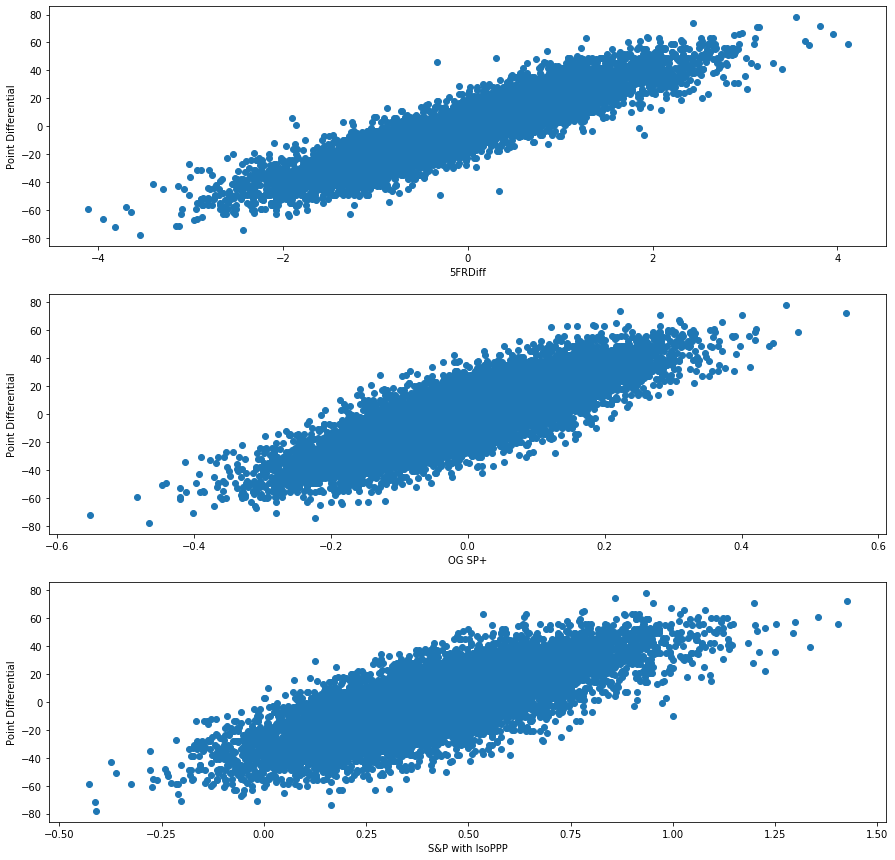

In [218]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [187]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [188]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Unnamed: 0,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.424200,1.015913,1.008803,1.907384
1,1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.575800,-1.015913,1.008803,1.907384
2,2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.144444,-0.212660,0.211171,0.181656
3,3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.855556,0.212660,0.211171,0.181656
4,4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.756652,-0.807733,0.802080,0.499553


In [189]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [190]:
# outliers

In [191]:
train_data.head()

,Unnamed: 0,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
1,1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,...,0.22,0,-0.122680,-4.387538,-0.041520,-0.006633,4.575800,-1.015913,1.008803,1.907384
4,4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,...,0.00,0,0.087917,-6.578618,0.261670,0.059391,4.756652,-0.807733,0.802080,0.499553
5,5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,...,0.00,0,-0.087917,6.578618,-0.261670,-0.059391,5.243348,0.807733,0.802080,0.499553
6,6,UCLA,2012,322430242,49.0,25.0,0.361313,0.528571,0.128571,9.042857,...,0.00,0,0.172590,9.625505,0.177623,0.013919,5.353939,0.869965,0.863877,1.135348
7,7,Rice,2012,322430242,24.0,-25.0,0.638687,0.423077,0.089744,5.141026,...,0.00,0,-0.172590,-9.625505,-0.177623,-0.013919,4.646061,-0.869965,0.863877,1.135348


In [192]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [193]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 20.16125x + -0.04439
Mean Pred Score: -0.0752091239745759
Pred Std Dev: 19.839942174555816
Mean Abs Error: 6.498947391850825
Mdn Abs Error: 5.095260679889591
R-squared: 0.8416948232248403



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.758631,0.566702,0.503628,0.797746,0.590474,0.591141,0.982878,0.512731,0.771062,-0.472172,-0.439390,0.715755,0.753642,0.208021,0.552829,0.893329,0.917512,0.917512
OffSRDiff,0.758631,1.000000,0.470620,0.301290,0.689578,0.386674,0.425013,0.751979,0.742833,0.697521,-0.282591,-0.159899,0.618855,0.752843,-0.099934,0.548930,0.836848,0.800935,0.800935
OffERDiff,0.566702,0.470620,1.000000,0.179721,0.507134,0.294793,0.320165,0.554169,0.324540,0.801438,-0.220094,-0.110887,0.755261,0.615544,0.552436,0.223808,0.517958,0.560196,0.560196
FPDiff,0.503628,0.301290,0.179721,1.000000,0.607900,0.118883,0.101451,0.480055,0.061567,0.244644,-0.303199,-0.375153,0.235019,0.241966,0.018765,0.271299,0.600988,0.649388,0.649388
OppRateDiff,0.797746,0.689578,0.507134,0.607900,1.000000,0.199952,0.193044,0.798136,0.263974,0.668195,-0.324143,-0.295986,0.592694,0.746883,0.127078,0.514282,0.798894,0.900124,0.900124
OppEffDiff,0.590474,0.386674,0.294793,0.118883,0.199952,1.000000,0.736750,0.588321,0.480071,0.416081,-0.306073,-0.297060,0.390011,0.351747,0.142794,0.319525,0.491478,0.455800,0.455800
OppPPDDiff,0.591141,0.425013,0.320165,0.101451,0.193044,0.736750,1.000000,0.599287,0.544593,0.455824,-0.318619,-0.277751,0.429960,0.366610,0.157288,0.341382,0.545475,0.515273,0.515273
PPDDiff,0.982878,0.751979,0.554169,0.480055,0.798136,0.588321,0.599287,1.000000,0.500073,0.758229,-0.461124,-0.430542,0.704161,0.731747,0.201284,0.554317,0.883008,0.910668,0.910668
OppSRDiff,0.512731,0.742833,0.324540,0.061567,0.263974,0.480071,0.544593,0.500073,1.000000,0.505405,-0.238194,-0.113544,0.459037,0.446638,-0.067703,0.373255,0.599648,0.526251,0.526251
YPPDiff,0.771062,0.697521,0.801438,0.244644,0.668195,0.416081,0.455824,0.758229,0.505405,1.000000,-0.340739,-0.190825,0.913426,0.791912,0.508650,0.461767,0.720334,0.754456,0.754456


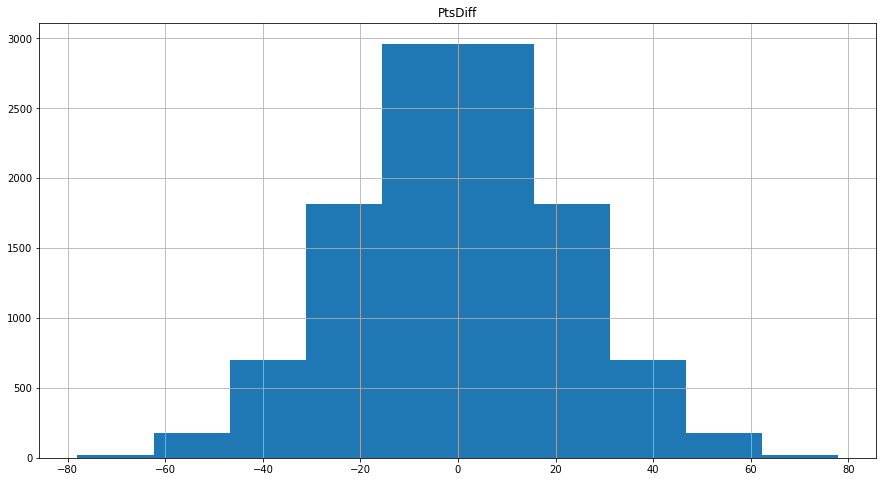

In [194]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

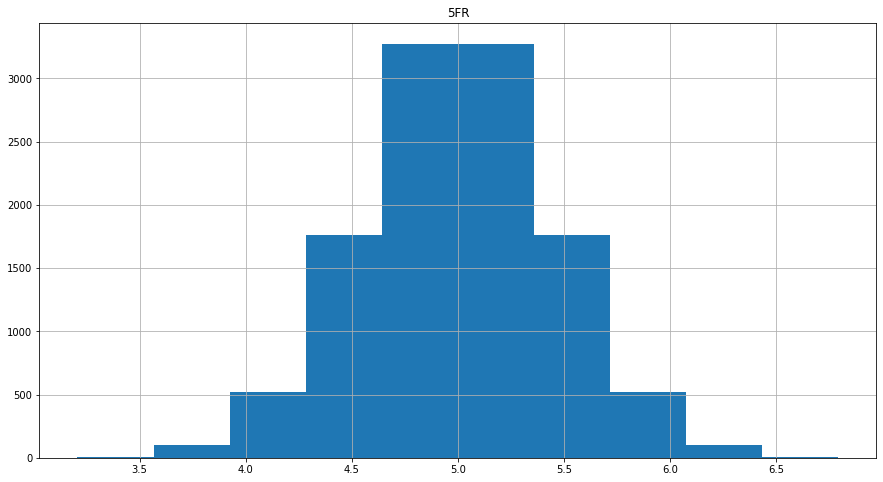

In [195]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

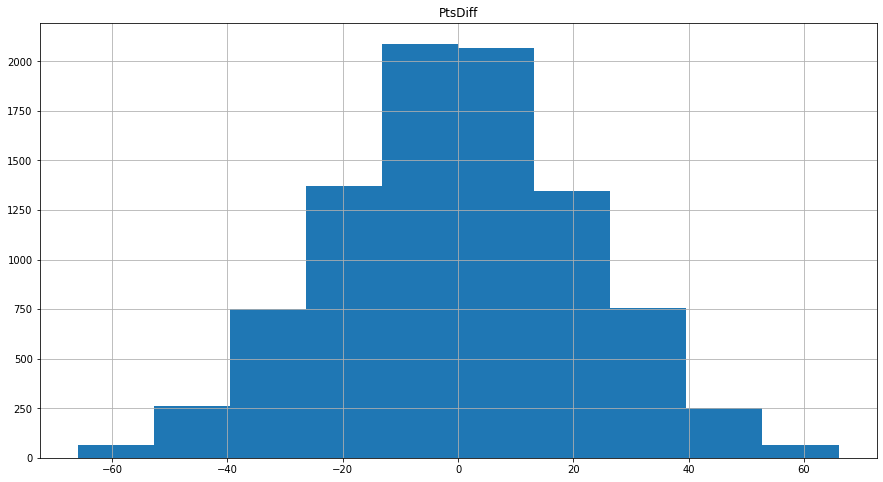

In [196]:
train_data.hist(column='PtsDiff', figsize=(15,8));

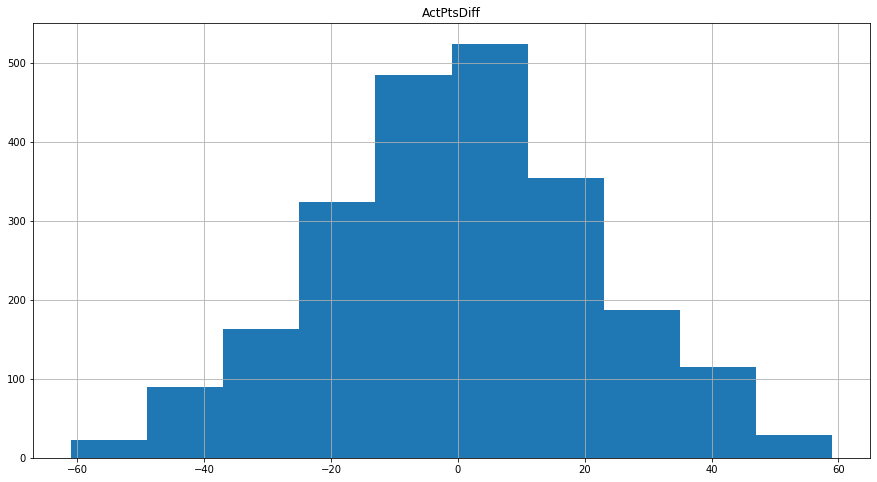

In [197]:
test.hist(column='ActPtsDiff', figsize=(15,8));

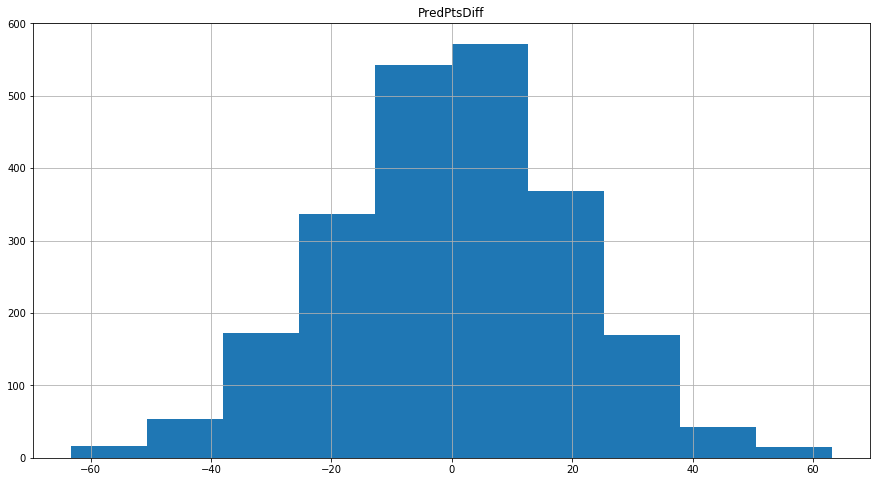

In [198]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [199]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [200]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -4.319648604098743)
Z score: -0.21393406506837231
Win Prob for Virginia Tech: 41.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.106027,0.212053
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.893973,-0.212053


In [201]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -15.576253025063759)
Z score: -0.7813048931649029
Win Prob for Georgia Tech: 21.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.614809,-0.770382
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.385191,0.770382


In [202]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -5.0 (exact value: -5.0829381383242325)
Z score: -0.25240643194877516
Win Prob for Georgia Tech: 40.04%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.124956,0.249913
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.875044,-0.249913


In [203]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 5.0 (exact value: 4.8446186247095575)
Z score: 0.24797591169361763
Win Prob for Mississippi State: 59.79%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.878752,-0.242495
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.121248,0.242495


In [204]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -6.0 (exact value: -6.119395843923283)
Z score: -0.3046473959838558
Win Prob for Texas A&M: 38.03%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.15066,0.301321
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.84934,-0.301321


In [205]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Clemson,0.943645,13,12.0,1.0
2,Ohio State,0.942055,13,12.0,1.0
3,Alabama,0.922291,12,11.0,1.0
4,LSU,0.895952,13,12.0,1.0
5,Utah,0.857759,13,11.0,2.0
6,Oregon,0.849505,13,11.0,2.0
7,Wisconsin,0.843955,13,11.0,2.0
8,Notre Dame,0.822572,12,10.0,2.0
9,Georgia,0.817329,13,11.0,2.0
10,Oklahoma,0.793168,13,10.0,3.0


In [206]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.563133,1.436867
21,Clemson,10.782505,2.217495
53,LSU,10.186077,2.813923
115,Utah,9.406520,3.593480
2,Alabama,9.354937,2.645063
128,Wisconsin,9.182645,3.817355
82,Oregon,8.995911,4.004089
75,Notre Dame,8.838132,3.161868
34,Georgia,8.835719,4.164281
78,Oklahoma,8.827203,4.172797


In [207]:
# Matchup Predictor?
def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    if (~(teams[teams.school == team1].conference.isin(p5).all())):
        team1_avg_ffr *= 0.85 # arbitrary
    if (~(teams[teams.school == team2].conference.isin(p5).all())):
        team2_avg_ffr *= 0.85 # arbitrary
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.05079811745094427, -32.556445554621995]

In [208]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Clemson,Ohio State,2.5,12.244457,0.732685,True,Clemson,Clemson
0,Penn State,Memphis,7.0,9.617310,0.687415,True,Penn State,Penn State
0,Florida,Virginia,14.0,7.439286,0.647565,False,Florida,Virginia
0,LSU,Oklahoma,11.0,7.366161,0.646196,False,LSU,Oklahoma
0,Wisconsin,Oregon,2.5,-3.756473,0.426400,False,Oregon,Oregon
0,Georgia,Baylor,7.5,-4.953270,0.402891,False,Baylor,Baylor


In [209]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 7.0 (exact value: 7.402883157607731)
Z score: 0.3769210724400576
Win Prob for Virginia: 64.69%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.815307,-0.369385
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.184693,0.369385


In [210]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 10.0 (exact value: 9.940346520637105)
Z score: 0.5048177840687639
Win Prob for North Carolina: 69.32%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.247622,0.495244
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.752378,-0.495244


In [211]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 11.0 (exact value: 11.326974130173772)
Z score: 0.5747084922843846
Win Prob for Pittsburgh: 71.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.28201,0.564021
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.71799,-0.564021


In [212]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -7.0 (exact value: -6.558339823292782)
Z score: -0.3267716529755134
Win Prob for Auburn: 37.19%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.161546,0.323093
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.838454,-0.323093


In [213]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 25.0 (exact value: 25.20923130840412)
Z score: 1.2744210749165037
Win Prob for Georgia: 89.87%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.626291,1.252582
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.373709,-1.252582


In [214]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 18.0 (exact value: 18.190717316197684)
Z score: 0.9206642982860007
Win Prob for Clemson: 82.14%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 2.0 (exact value: 1.5269098071018326)
Z score: 0.08075219761129557
Win Prob for Georgia Tech: 53.22%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -15.0 (exact value: -14.527173375877185)
Z score: -0.728427740602836
Win Prob for The Citadel: 23.32%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 23.0 (exact value: 22.569676907771722)
Z score: 1.141378630668982
Win Prob for Temple: 87.31%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 10.0 (exact value: 9.940346520637105)
Z score: 0.5048177840687

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,17.861286
5900,401112441,2019,Georgia Tech,South Florida,4.0,53.218049
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,76.682411
6107,401112469,2019,Georgia Tech,Temple,-22.0,12.685620
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,30.684341
6198,401112480,2019,Georgia Tech,Duke,-18.0,31.373761
6251,401112488,2019,Georgia Tech,Miami,7.0,21.731160
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,28.274423
6418,401112504,2019,Georgia Tech,Virginia,-5.0,24.277103
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.218506


In [215]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)